In [18]:
!pip install minisom

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
import math
from minisom import MiniSom
import numpy as np
from tslearn.metrics import soft_dtw
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
%matplotlib inline

In [20]:
plt.rc('font', family='NanumGothic')

In [21]:
data = pd.read_csv('크롤링1234.csv', encoding='euc-kr')

In [22]:
data.head()

,코드,재무,상품,산업군,특허,인증
0,1.058603e+09,결산년도 총자산 자본금 자본...,특허검색서비스,데이터베이스 및 온라인정보 제공업,"['10-1623902,2016', '10-1575797,2015', '10-157...","['이노비즈인증,2018', '경영혁신형중소기업,2016', '벤처기업확인,2014']"
1,1.058528e+09,Empty DataFrame\nColumns: [결산년도 총자산 자본금 자본총계 매...,정보없음,정보없음,정보없음,정보없음
2,1.058668e+09,결산년도 총자산 자본금 자본총계 ...,위성 및 항공영상 처리 S/W,응용소프트웨어 개발 및 공급업,[],"['벤처기업확인,2020', '이노비즈인증,2018']"
3,1.138186e+09,결산년도 총자산 자본금 자본총계 ...,냉동공조제품,배관 및 냉·난방 공사업,[],[]
4,2.288701e+09,결산년도 총자산 자본금 자본총계 ...,정보없음,응용소프트웨어 개발 및 공급업,[],[]


SOM 모델 적용

재무 칼럼의 데이터프레임화

In [23]:
sales = []
money = []
biz_code = []

for i in range(len(data)):
    sales.append(data.iloc[i,1])
    if len(sales[i].split()) == 47:
        test = pd.DataFrame({sales[i].split()[0]: sales[i].split()[8::8], sales[i].split()[1]: sales[i].split()[9::8], sales[i].split()[2]: sales[i].split()[10::8],
                    sales[i].split()[3]: sales[i].split()[11::8], sales[i].split()[4]: sales[i].split()[12::8], sales[i].split()[5]: sales[i].split()[13::8],
                    sales[i].split()[6]: sales[i].split()[14::8]})
        money.append(test)
        biz_code.append(data.iloc[i,0])

연도 > 시계열타입 , 인덱스 재설정

In [25]:
for i in range(len(money)):
    money[i]['결산년도'] = pd.to_datetime(money[i]['결산년도'])
    money[i].set_index(money[i]['결산년도'], inplace=True)
    money[i] = money[i].sort_index()
    money[i].drop('결산년도',axis=1,inplace=True)

In [28]:
for m in range(len(money)):
    if len(money[m].columns) == 6:
        for n in range(len(money[m])):
            if len(money[m].columns) == 6 and money[m].iloc[n,3] == '0':
                money[m].drop(labels = '매출액', axis=1, inplace=True)
            elif len(money[m].columns) != 6:
                pass
    else:
        pass

In [29]:
for m in range(len(money)):
    money[m] = money[m].astype(float)
    money[m]['부채액'] = (money[m]['총자산'] - money[m]['자본총계']) * 0.05
    money[m]['총자산'] = money[m]['총자산'] * 0.35
    money[m]['자본총계'] = money[m]['자본총계'] * 0.05
    money[m]['매출액'] = money[m]['매출액'] * 0.35
    money[m]['영업이익'] = money[m]['영업이익'] * 0.1

In [33]:
money2 = []    
    
for i in range(len(money)):
    if len(money[i].columns) == 6:
        money2.append(money[i])

In [57]:
for m in range(len(money)):
    if len(money[m].columns) == 6:
        for n in range(len(money[m])):
            if len(money[m].columns) == 6 and money[m].iloc[n,3] == '0':
                money[m].drop(labels = '매출액', axis=1, inplace=True)
            elif len(money[m].columns) != 6:
                pass
    else:
        pass
for m in range(len(money2)):
    money2[m] = money2[m].astype(float)
    money2[m]['부채'] = money2[m]['총자산'] - money2[m]['자본총계']
    money2[m]['총자산'] = money2[m]['총자산'] * 0.35
    money2[m]['자본총계'] = money2[m]['자본총계'] * 0.05
    money2[m]['매출액'] = money2[m]['매출액'] * 0.35
    money2[m]['영업이익'] = money2[m]['영업이익'] * 0.1
    money2[m]['부채'] = money2[m]['부채'] * 0.05
    money2[m]['CRscore'] = money2[m]['총자산'] + money2[m]['자본총계'] + money2[m]['매출액'] + money2[m]['영업이익'] + money2[m]['부채']
    money2[m] = money2[m]['CRscore']

In [8]:
money[0]

,총자산,자본금,자본총계,매출액,영업이익,당기순이익
결산년도,,,,,,
2020-12-31,1505467,300000,506084,1913572,91955,62577
2019-12-31,1316809,300000,443507,1933556,78978,60111
2018-12-31,1056650,150000,233396,2061116,78423,59344
2017-12-31,998327,150000,174051,3056020,71254,52384
2016-12-31,749586,150000,121667,578239,-141578,-156132


In [9]:
#매출데이터 = pd.DataFrame()
#for i in range(len(money)):
#    mmm = pd.DataFrame(money[i]['매출액']).transpose()
#    매출데이터 = pd.concat([매출데이터, mmm], axis=0)
#nnn = pd.DataFrame(biz_code)
#매출데이터.index = nnn.iloc[:,0]
#매출데이터.columns = money[0]['결산년도']
#매출데이터 = 매출데이터.iloc[:,::-1]

In [10]:
#x_train, x_test, y_train, y_test = train_test_split(매출데이터.iloc[:,:-1], 매출데이터.iloc[:,-1], test_size=0.2, shuffle=True, random_state=1)

In [11]:
len(money) / 5

788.0

In [12]:
len(money)

3940

In [13]:
# money_train = []

# for i in range(len(x_train)):
#     tmp_train = pd.DataFrame(x_train.iloc[i,:])
#     tmp_train.columns = ['매출액']
#     money_train.append(tmp)
    
#     tmp_test = pd.DataFrame(x_test)

매출액 시계열 시각화
(다 시각화 하기엔 무리라서 예시로 조금 함)

IndexError: list index out of range

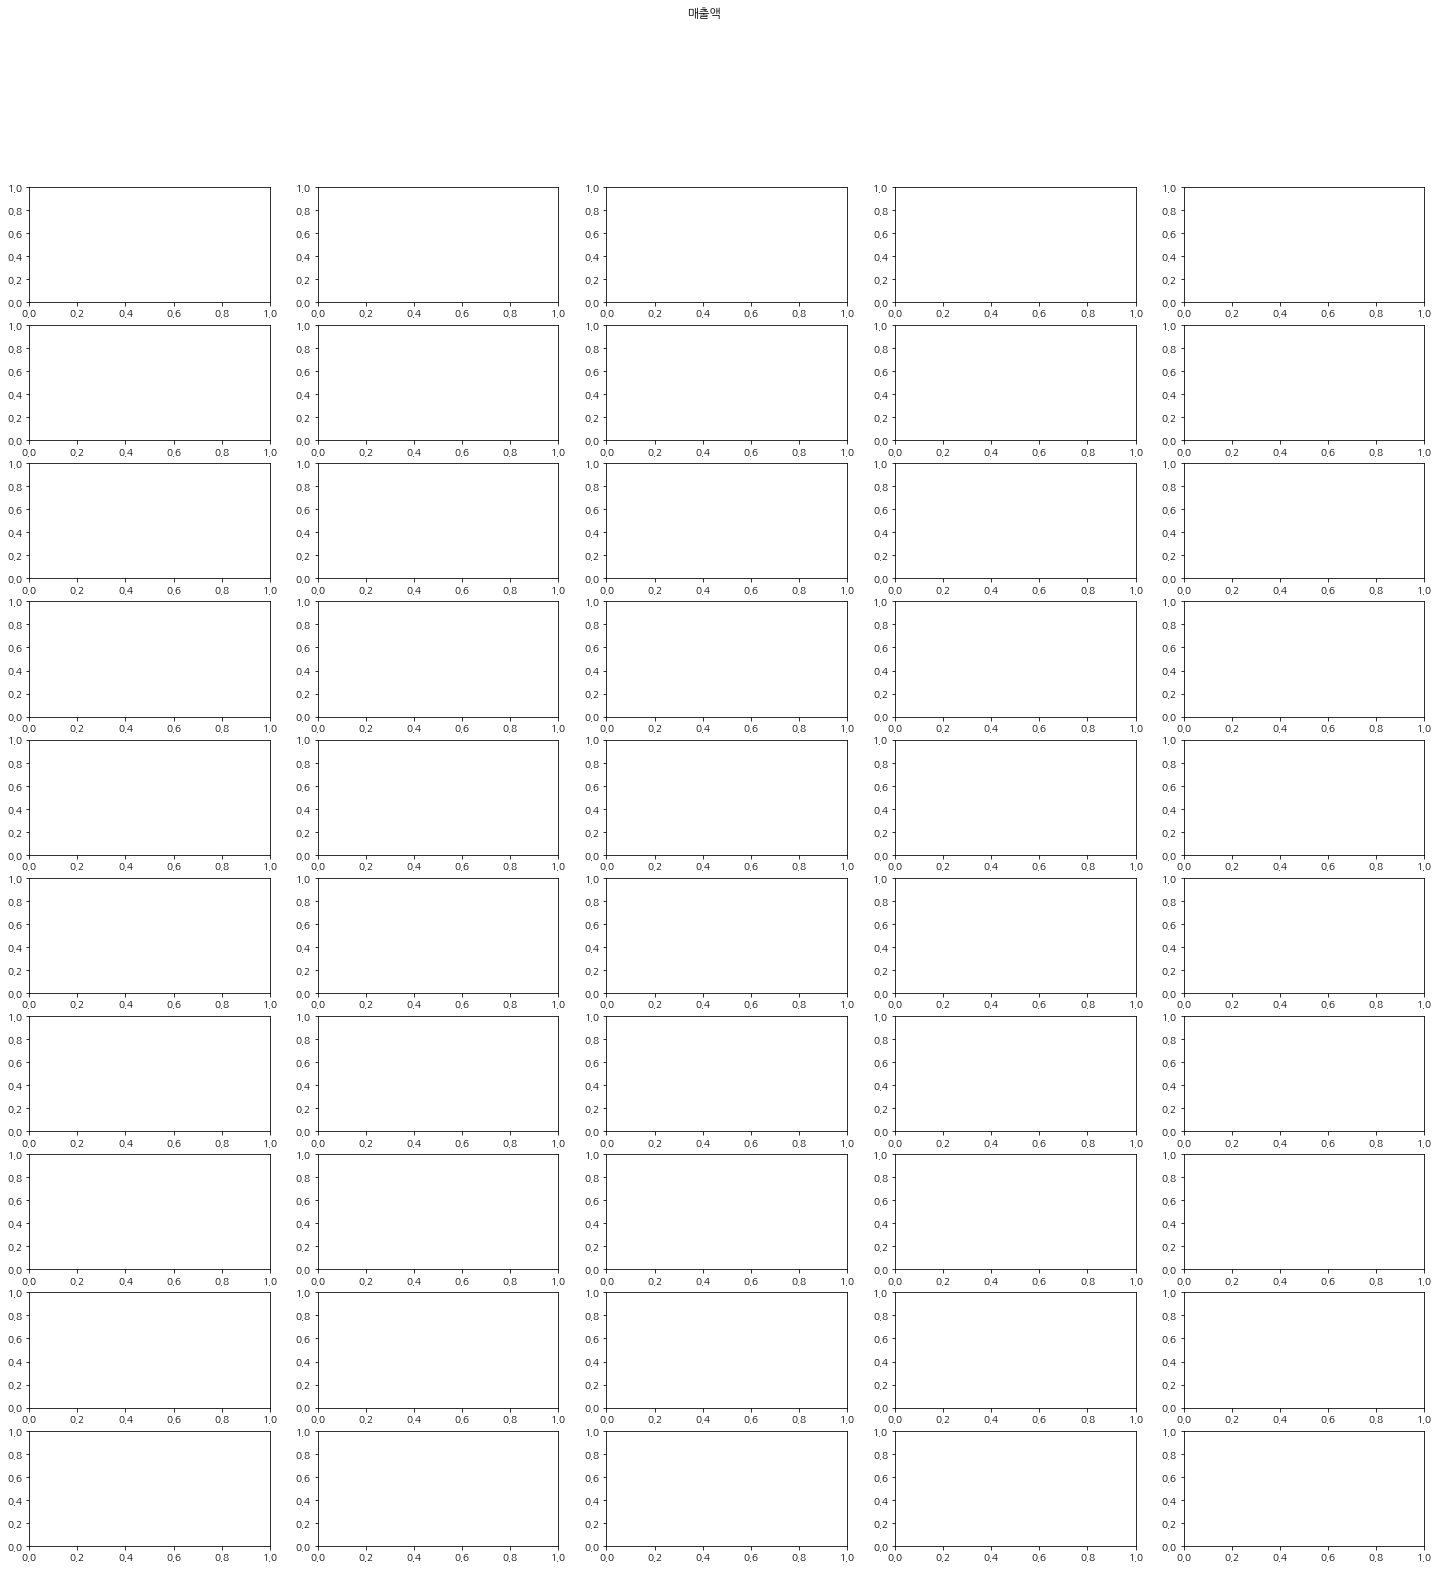

In [58]:
fig, axs = plt.subplots(10,5,figsize=(25,25))
fig.suptitle('매출액')

for i in range(10):
    for j in range(5):
        if i*5+j+1>len(money): # pass the others that we can't fill
            continue
        axs[i, j].plot(money2[i*5+j]['매출액'])
plt.show()

칼럼 내 데이터의 상대성 비교(minmaxscaler)

In [79]:
def z_score_normalize(lst):
    normalized = []
    for value in lst:
        normalized_num = (value - np.mean(lst)) / np.std(lst)
        normalized.append(normalized_num)
    return normalized

In [80]:
money_z = []
for i in range(len(money2)):
    money_z.append(z_score_normalize(money2[i]))

SOM 군집화 모델 적용(자기 조직화 지도)

In [81]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(money2))))

for i in range(len(money2)):
    som = MiniSom(som_x, som_y,len(money2[0]), sigma=0.3, learning_rate = 0.1)
    som.random_weights_init(money2)
    som.train(money2, 100)

In [82]:
def plot_money_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

In [83]:
win_map = som.win_map(money2)

plot_money_averaged_center(som_x, som_y, win_map)

NameError: name 'som' is not defined

군집 분포 시각화

In [ ]:
cluster_c = []
cluster_n = []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f"Cluster {cluster_number}")

plt.figure(figsize=(25,5))
plt.title("Cluster Distribution for SOM")
plt.bar(cluster_n,cluster_c)
plt.xticks(rotation=90)
plt.show()

사업자 번호 마킹

In [ ]:
cluster_map = []

for i in range(len(money)):
    winner_node = som.winner(money[i])
    cluster_map.append((biz_code[i],f"Cluster {winner_node[0]*som_y+winner_node[1]+1}"))

pd.DataFrame(cluster_map,columns=["사업자번호","Cluster"]).sort_values(by="Cluster").set_index("사업자번호")

In [ ]:
pd.DataFrame(cluster_map,columns=["사업자번호","Cluster"]).sort_values(by="Cluster").set_index("사업자번호").to_csv('SOM.csv',encoding='euc-kr')

K-Mean 군집 모델 적용

군집 수 미설정

In [246]:
cluster_count = math.ceil(math.sqrt(len(money))) 
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN
    
km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")

labels = km.fit_predict(money)

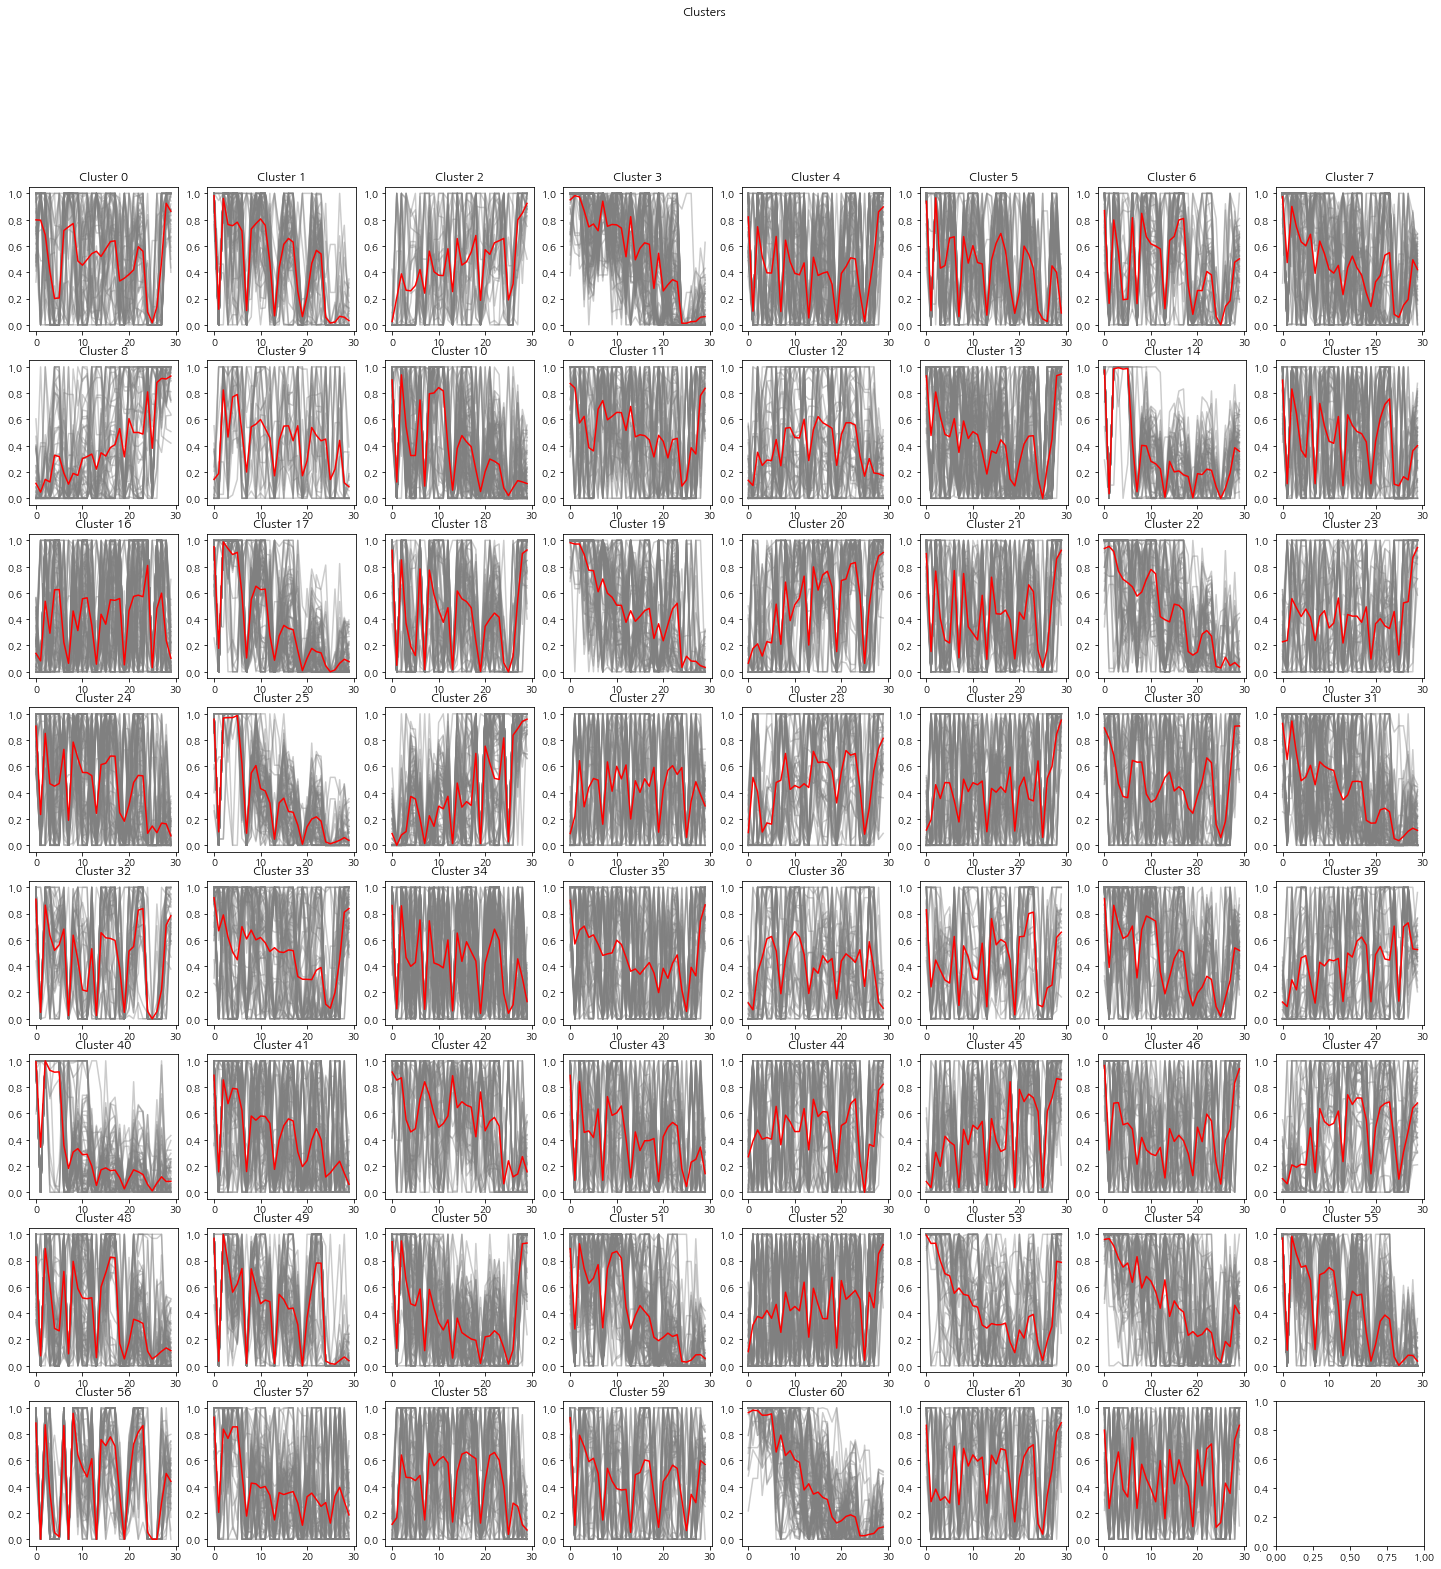

In [258]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(money[i],c="gray",alpha=0.4)
                cluster.append(money[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

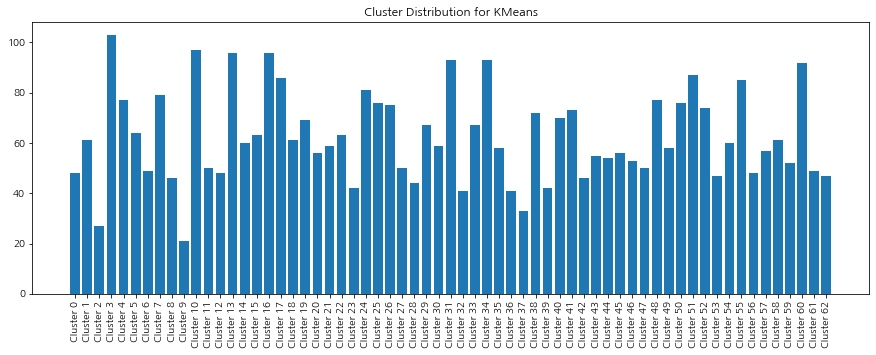

In [292]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.xticks(rotation=90)
plt.show()

In [260]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
pd.DataFrame(zip(biz_code,fancy_names_for_labels),columns=["사업자번호","Cluster"]).sort_values(by="Cluster").set_index("사업자번호")

,Cluster
사업자번호,
2.148678e+09,Cluster 0
6.210495e+09,Cluster 0
1.288671e+09,Cluster 0
1.178148e+09,Cluster 0
1.138195e+09,Cluster 0
...,...
2.208873e+09,Cluster 9
1.148637e+09,Cluster 9
2.948100e+09,Cluster 9


In [307]:
score = silhouette_score(money, labels)
score

-0.09575129563208767

In [263]:
pd.DataFrame(zip(biz_code,fancy_names_for_labels),columns=["사업자번호","Cluster"]).sort_values(by="Cluster").set_index("사업자번호").to_csv('KM_군집수미설정.csv', encoding='euc-kr')

군집 수 3개로 설정

In [265]:
cluster_count2 = math.ceil(math.sqrt(len(money))) 
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN
    
km2 = TimeSeriesKMeans(n_clusters=3, metric="dtw")

labels2 = km2.fit_predict(money)

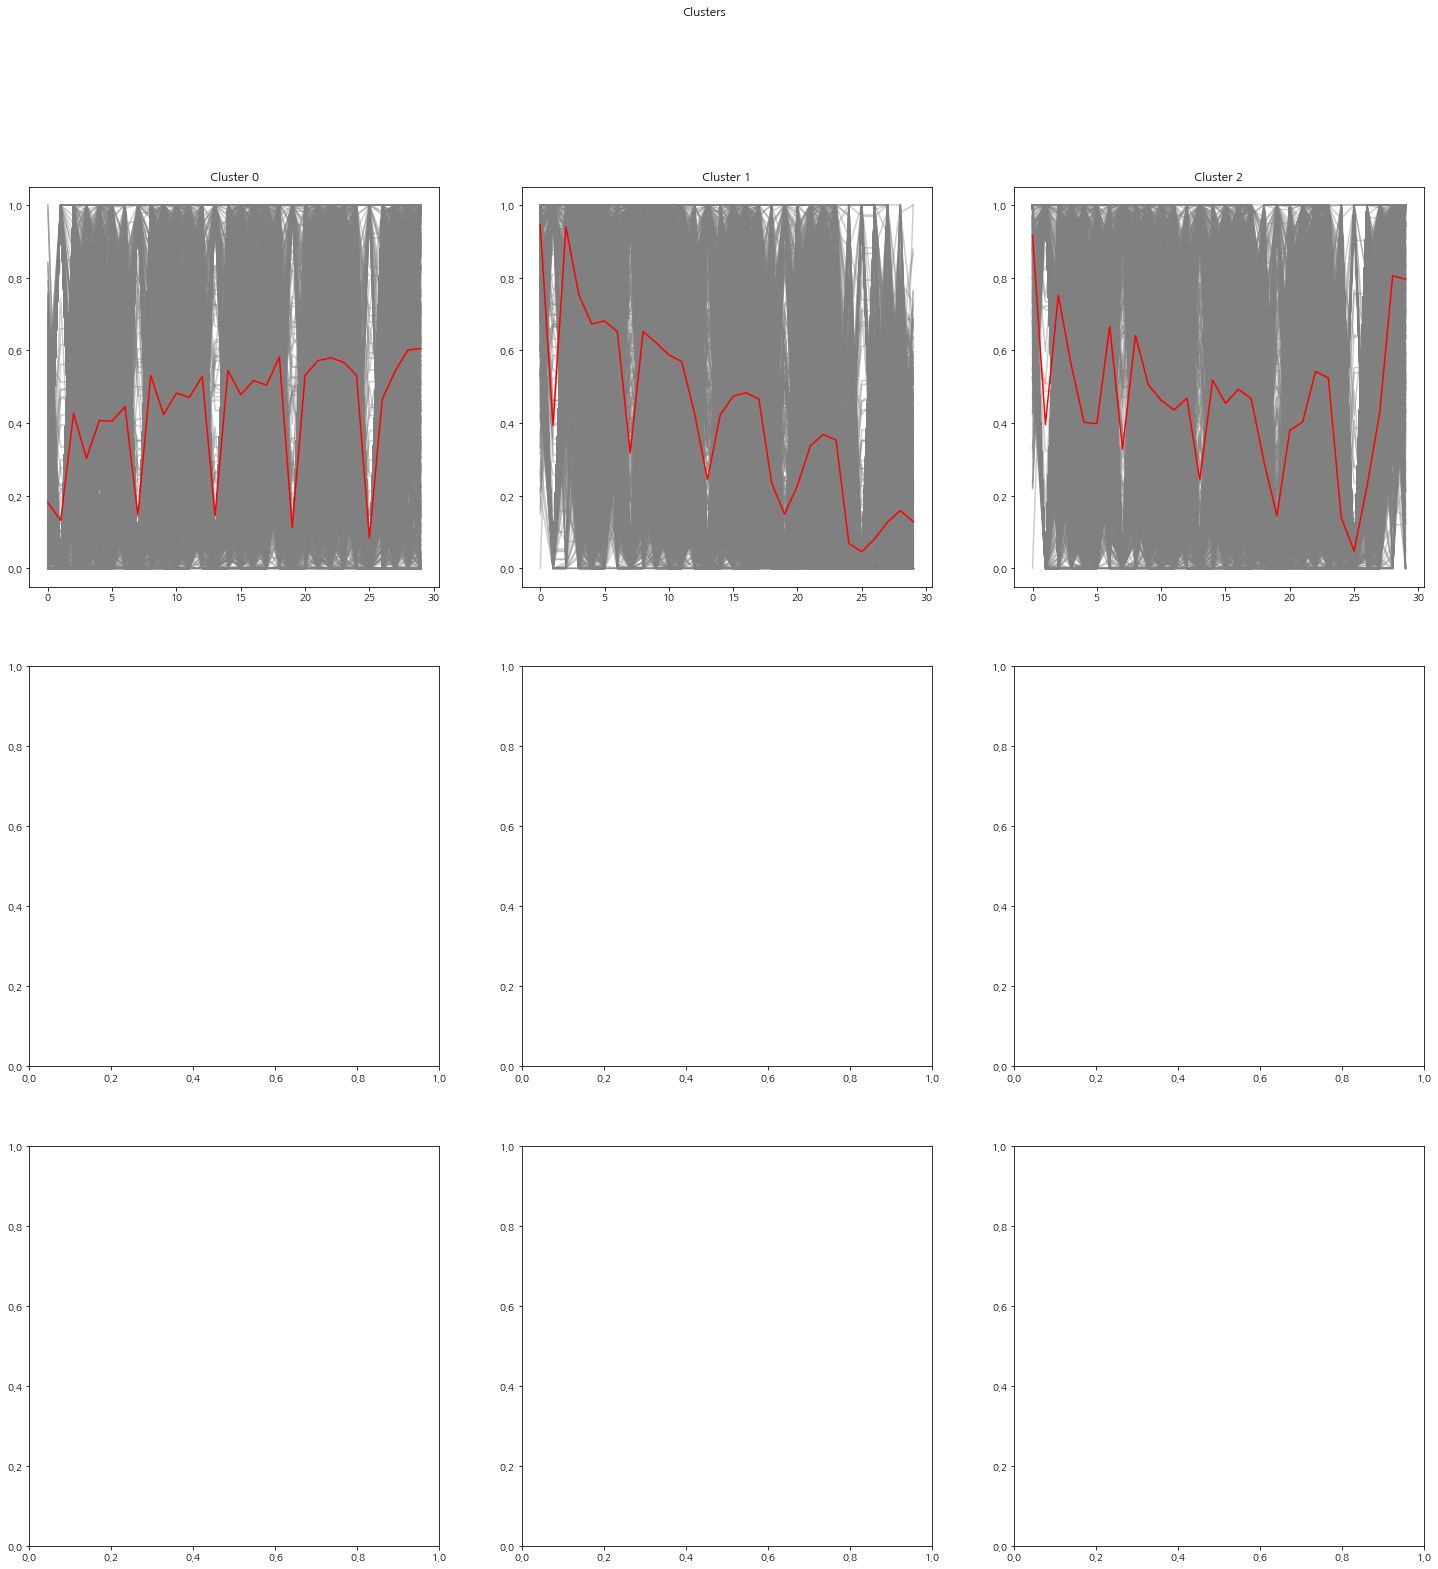

In [266]:
# plot_count = math.ceil(math.sqrt(cluster_count))
plot_count = 3

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels2):
    cluster = []
    for i in range(len(labels2)):
            if(labels2[i]==label):
                axs[row_i, column_j].plot(money[i],c="gray",alpha=0.4)
                cluster.append(money[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

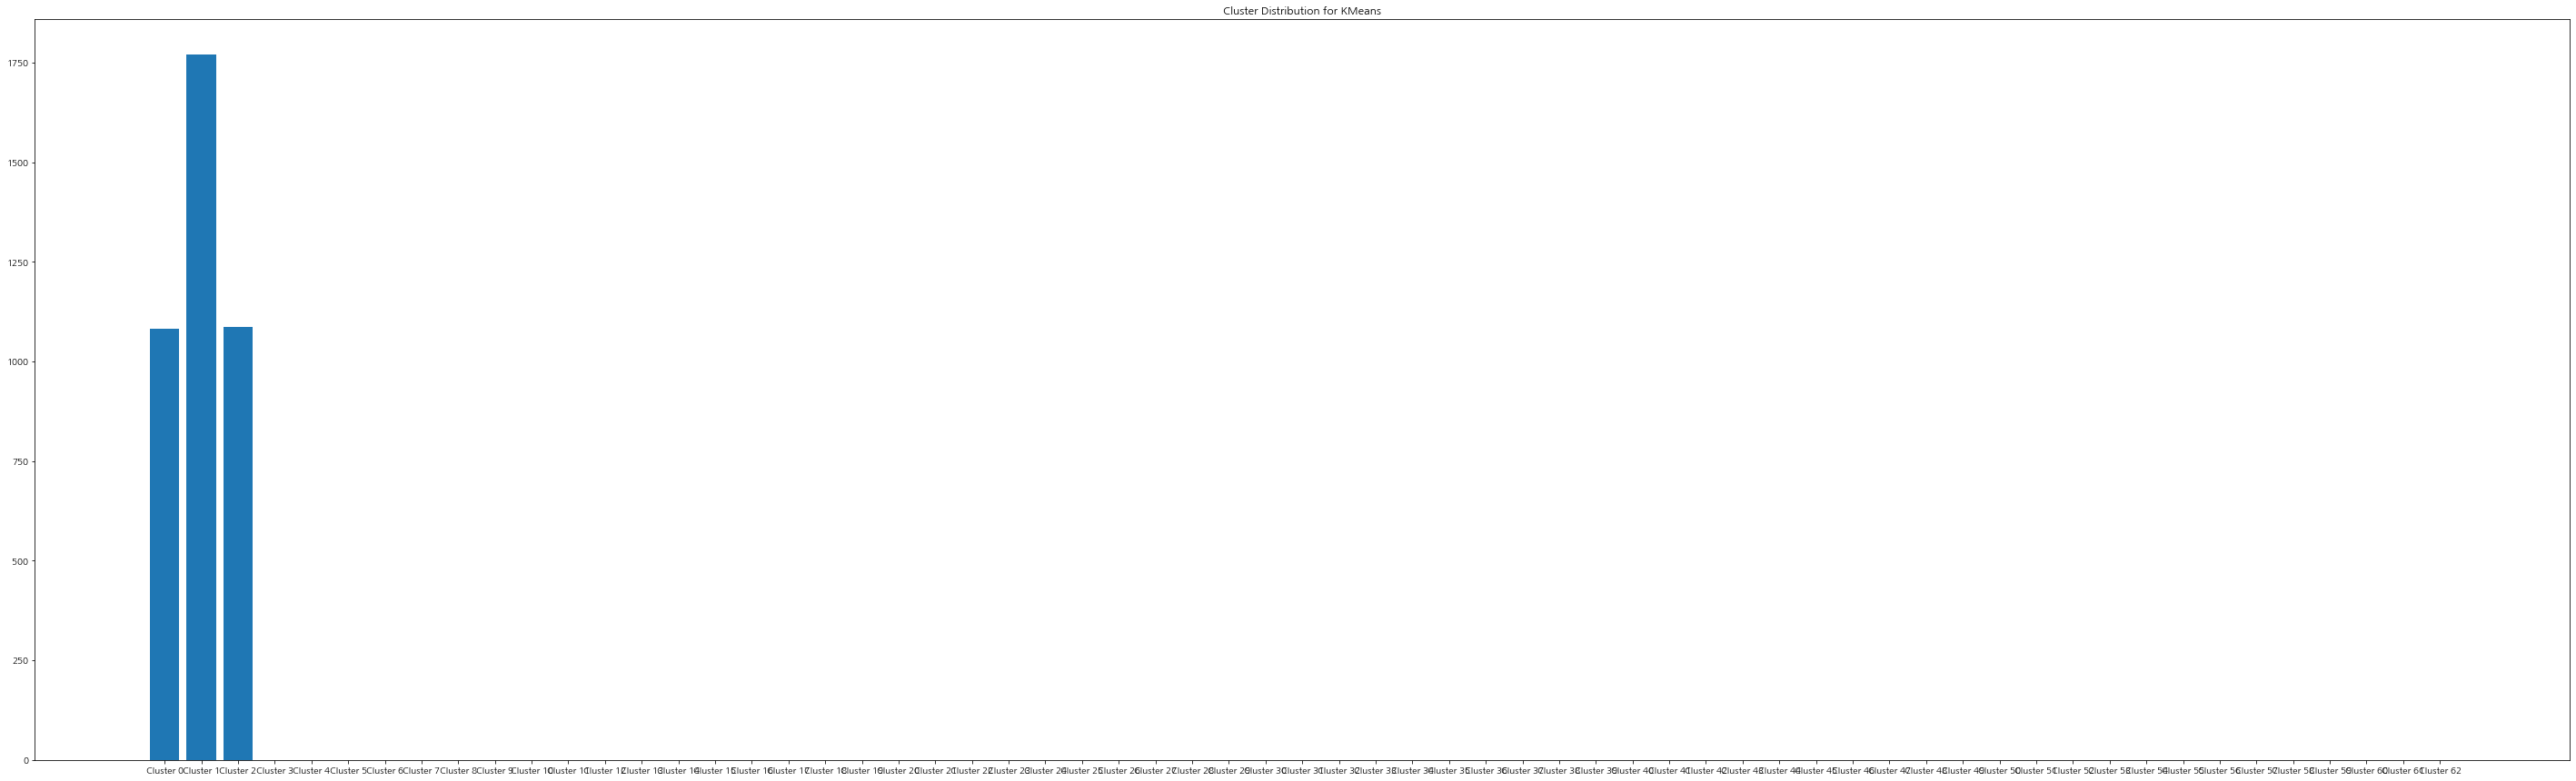

In [294]:
cluster_c = [len(labels2[labels2==i]) for i in range(cluster_count2)]
cluster_n = ["Cluster "+str(i) for i in range(cluster_count2)]
plt.figure(figsize=(50,15))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [290]:
fancy_names_for_labels2 = [f"Cluster {label}" for label in labels2]
pd.DataFrame(zip(biz_code,fancy_names_for_labels2),columns=["사업자번호","Cluster"]).sort_values(by="Cluster").set_index("사업자번호")

,Cluster
사업자번호,
1.148634e+09,Cluster 0
1.148673e+09,Cluster 0
2.148841e+09,Cluster 0
2.178134e+09,Cluster 0
1.208738e+09,Cluster 0
...,...
2.118864e+09,Cluster 2
1.088165e+09,Cluster 2
1.048626e+09,Cluster 2


In [304]:
score2 = silhouette_score(money, labels2)
score2

0.08424520990589554

In [291]:
pd.DataFrame(zip(biz_code,fancy_names_for_labels2),columns=["사업자번호","Cluster"]).sort_values(by="Cluster").set_index("사업자번호").to_csv('KM_군집수3.csv', encoding='euc-kr')

군집수 5

In [295]:
cluster_count3 = math.ceil(math.sqrt(len(money))) 
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN
    
km3 = TimeSeriesKMeans(n_clusters=5, metric="dtw")

labels3 = km3.fit_predict(money)

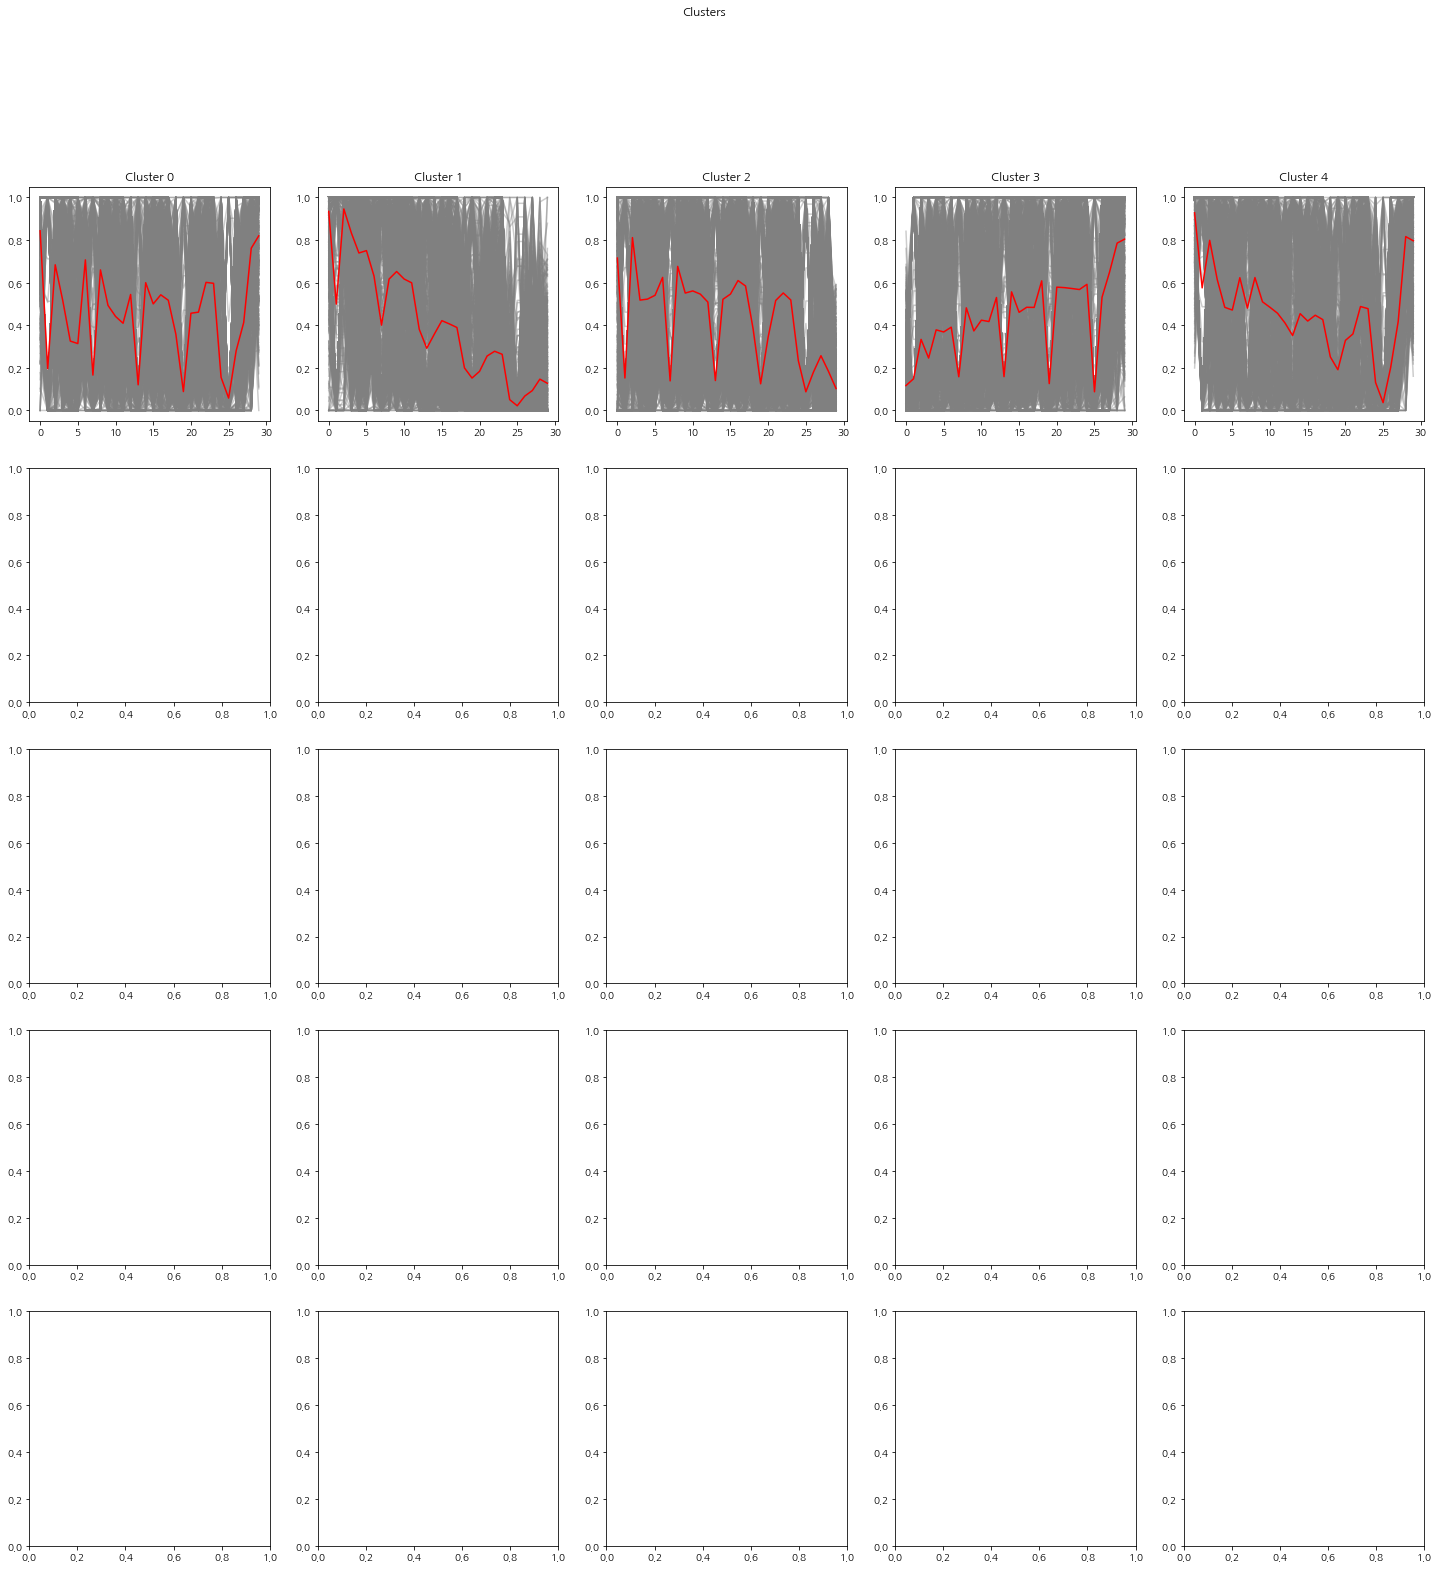

In [296]:
# plot_count = math.ceil(math.sqrt(cluster_count))
plot_count = 5

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels3):
    cluster = []
    for i in range(len(labels3)):
            if(labels3[i]==label):
                axs[row_i, column_j].plot(money[i],c="gray",alpha=0.4)
                cluster.append(money[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

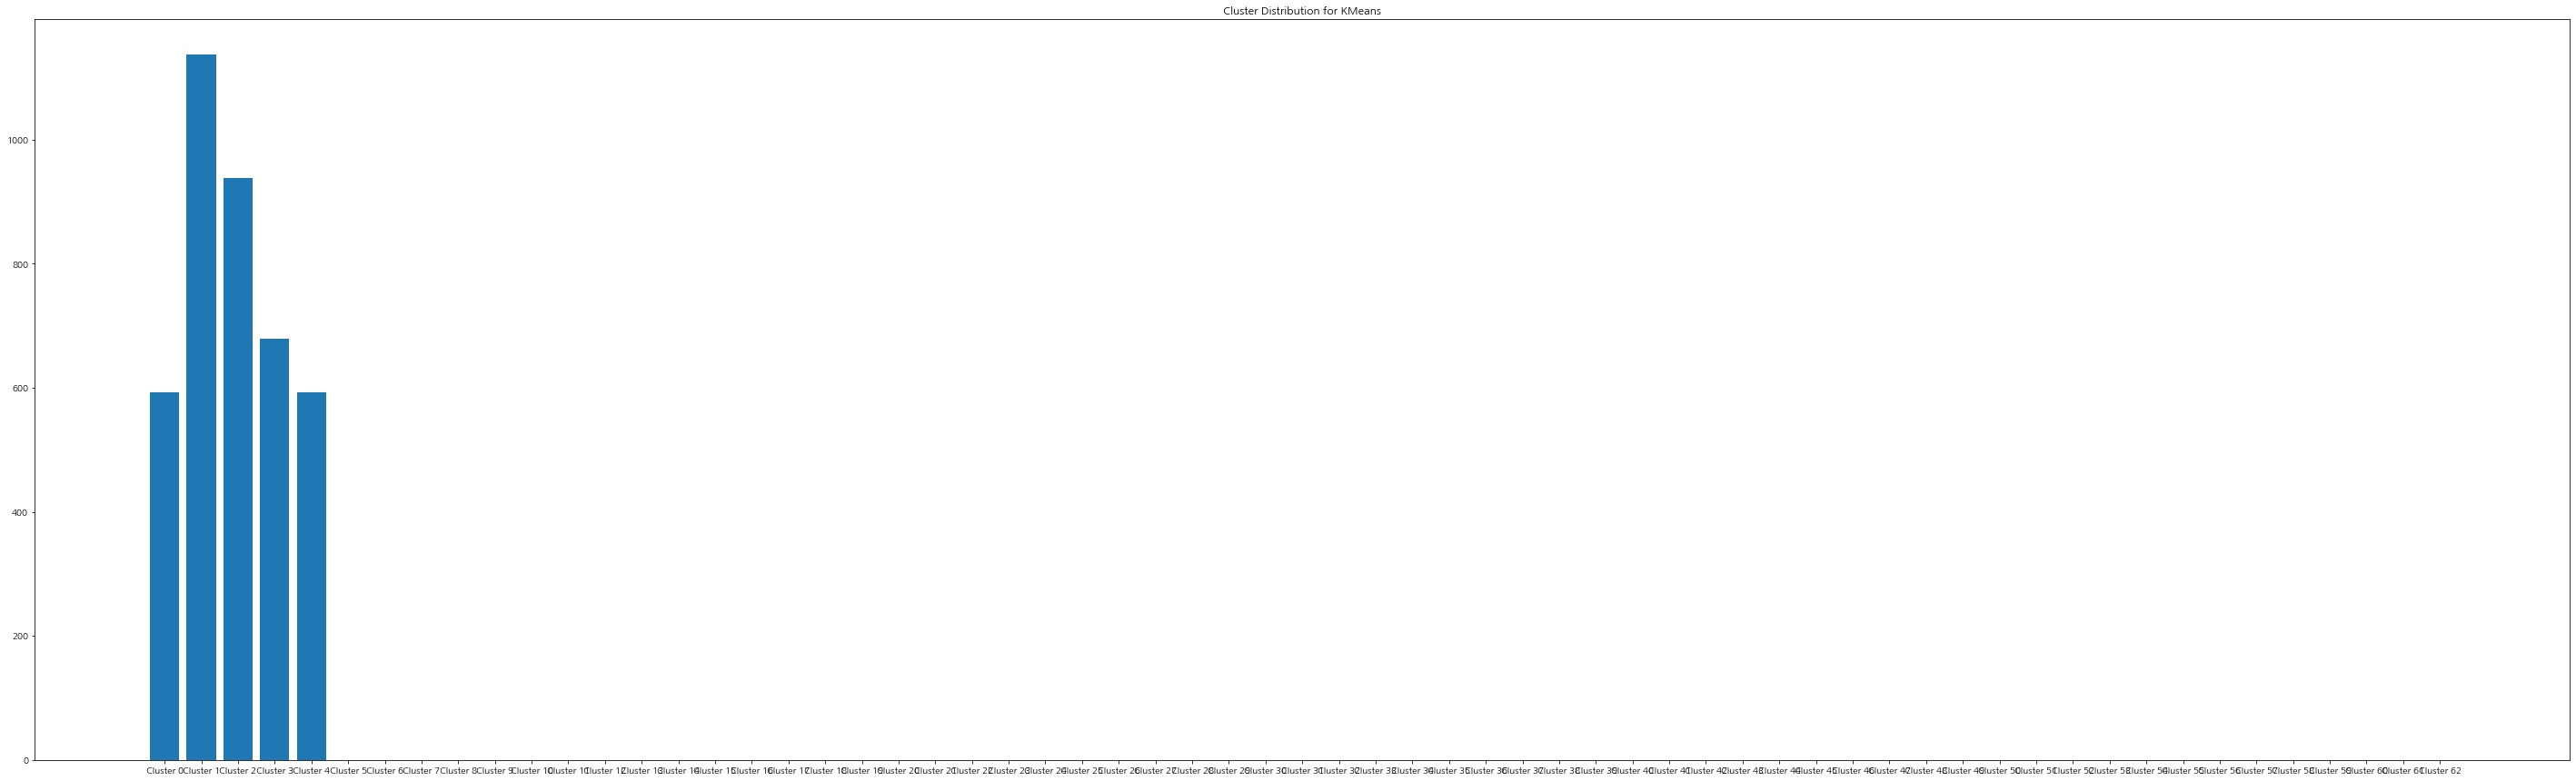

In [297]:
cluster_c = [len(labels3[labels3==i]) for i in range(cluster_count3)]
cluster_n = ["Cluster "+str(i) for i in range(cluster_count3)]
plt.figure(figsize=(50,15))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [298]:
fancy_names_for_labels3 = [f"Cluster {label}" for label in labels3]
pd.DataFrame(zip(biz_code,fancy_names_for_labels2),columns=["사업자번호","Cluster"]).sort_values(by="Cluster").set_index("사업자번호")

,Cluster
사업자번호,
1.148634e+09,Cluster 0
1.148673e+09,Cluster 0
2.148841e+09,Cluster 0
2.178134e+09,Cluster 0
1.208738e+09,Cluster 0
...,...
2.118864e+09,Cluster 2
1.088165e+09,Cluster 2
1.048626e+09,Cluster 2


In [299]:
pd.DataFrame(zip(biz_code,fancy_names_for_labels2),columns=["사업자번호","Cluster"]).sort_values(by="Cluster").set_index("사업자번호").to_csv('KM_군집수5.csv', encoding='euc-kr')

In [300]:
from sklearn.metrics import silhouette_score

In [303]:
score3 = silhouette_score(money, labels3)
score3

0.046226988275281475

---------------------

In [308]:
cluster_count4 = math.ceil(math.sqrt(len(money))) 
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN
    
km4 = TimeSeriesKMeans(n_clusters=20, metric="dtw")

labels4 = km4.fit_predict(money)

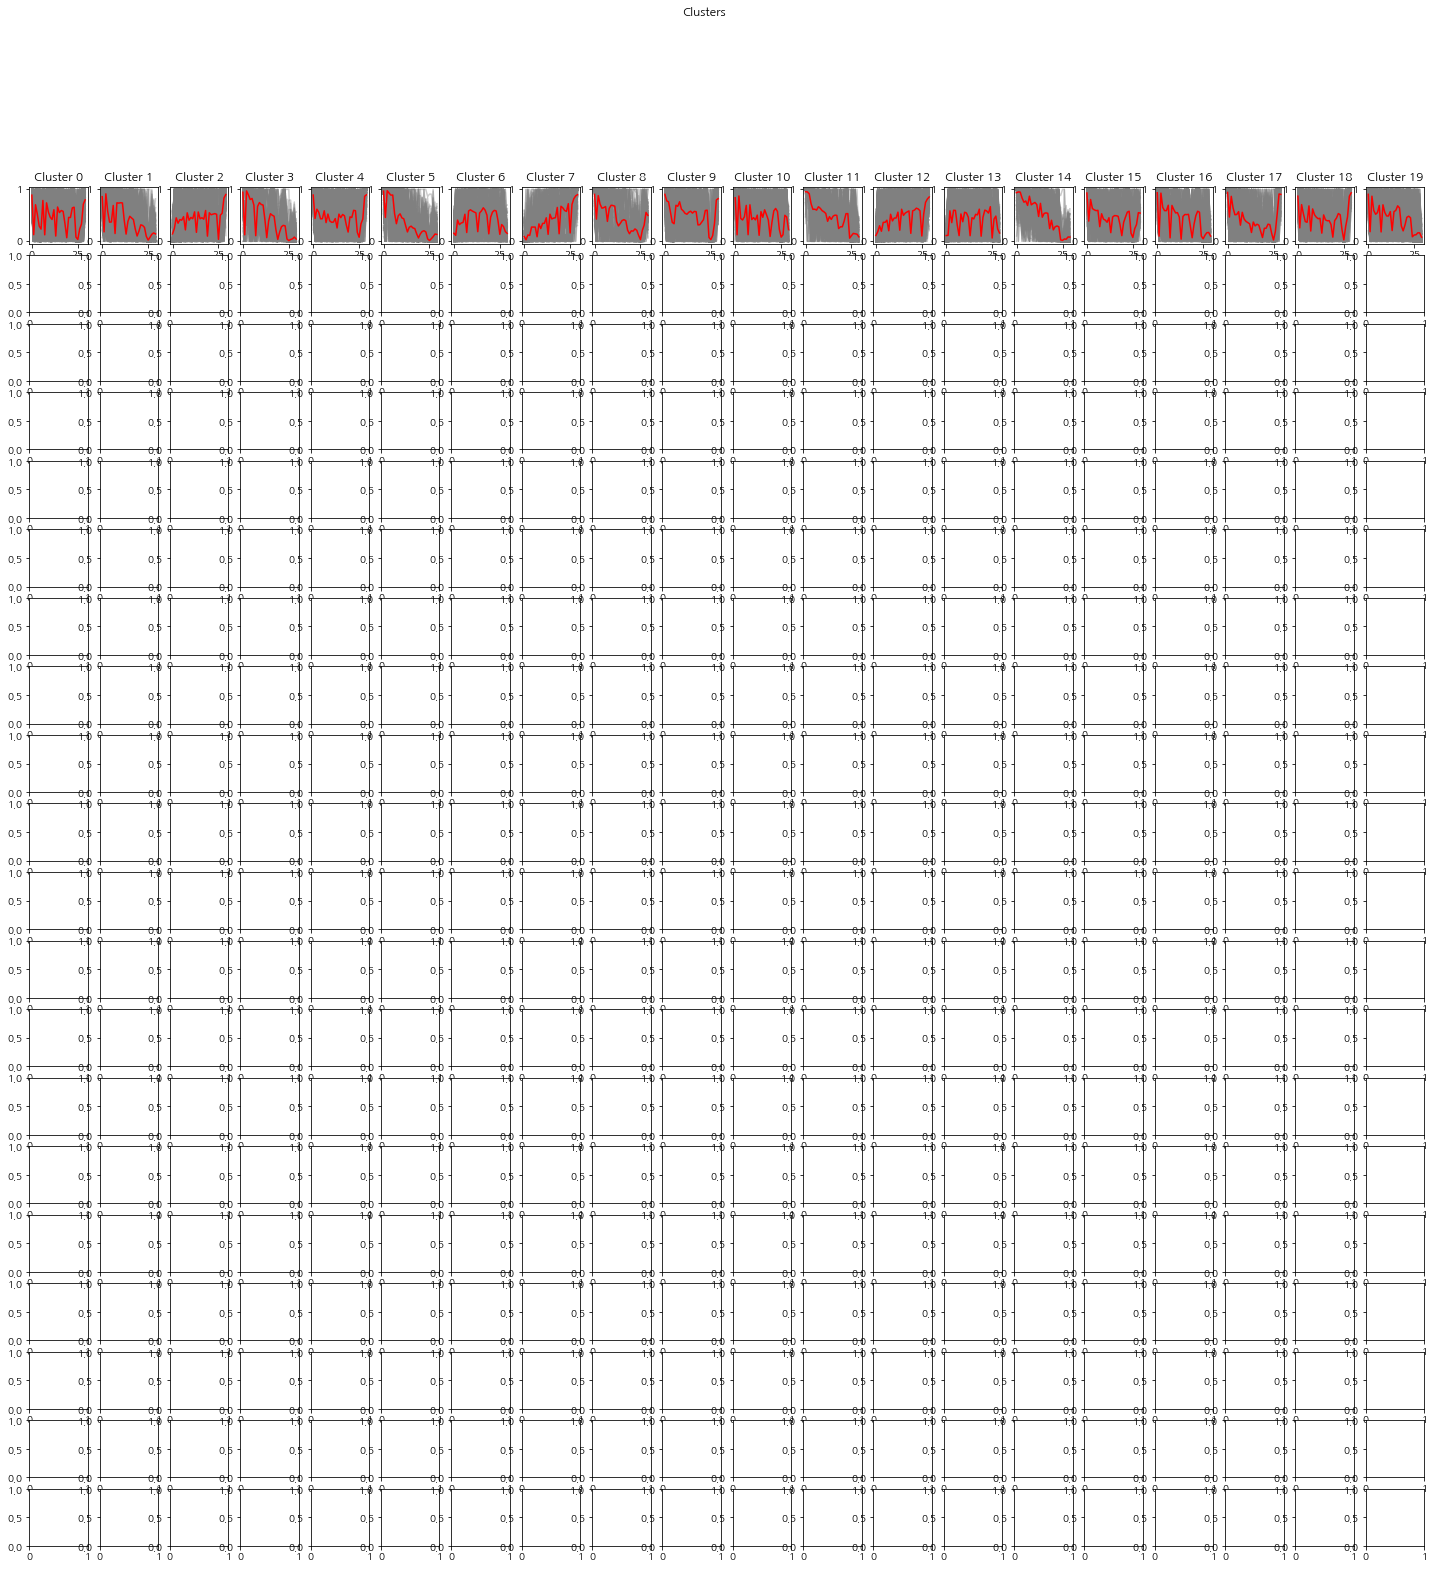

In [309]:
# plot_count = math.ceil(math.sqrt(cluster_count))
plot_count = 20

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels4):
    cluster = []
    for i in range(len(labels4)):
            if(labels4[i]==label):
                axs[row_i, column_j].plot(money[i],c="gray",alpha=0.4)
                cluster.append(money[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

In [310]:
score4 = silhouette_score(money, labels4)
score4

-0.03481088853012698

In [3]:
cluster_data = pd.read_csv('SOM기준병합.csv', encoding='euc-kr')

In [4]:
cluster_data

,Unnamed: 0,사업자번호,Cluster,산업분류코드,기업코드,최종연구개발점수,최종연구개발등급,연구개발투자점수,인적자원구성원 등급,연구개발기술지원점수,...,사업계획 점수,사업계획 등급,경제적 책임 점수,경제적 책임 등급,법률적 책임 점수,법률적 책임 등급,윤리적 책임 점수,윤리적 책임 등급,자선적 책임 점수,자선적 책임 등급
0,0,6138145291,Cluster 1,F42321,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1248127527,Cluster 1,F42321,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,3058172470,Cluster 1,J58221,151.0,82.5,B,45.0,A,22.5,...,80.0,B,100.0,A,100.0,A,100.0,A,50.0,D
3,3,2298130593,Cluster 1,J58222,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1058758282,Cluster 1,J59112,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4002,4002,2061049750,Cluster 9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4003,4003,2148768560,Cluster 9,J58221,1800.0,64.5,D,30.0,D,22.5,...,50.0,D,50.0,D,100.0,A,100.0,A,50.0,D
4004,4004,3148643616,Cluster 9,J62021,6084.0,64.5,D,30.0,D,22.5,...,50.0,D,55.0,D,100.0,A,100.0,A,50.0,D
4005,4005,2090388749,Cluster 9,J58222,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
increase_list = ['Cluster 3' , 'Cluster 5' , 'Cluster 32' , 'Cluster 36' , 'Cluster45' , 'Cluster 49' , 'Cluster 57' , 'Cluster 60']
increase_cluster = pd.DataFrame()

for cluster_group in increase_list:
    increase = cluster_data[cluster_data['Cluster'] == cluster_group]
    increase_cluster = pd.concat([increase_cluster, increase], axis=0)

In [6]:
keep_list = ['Cluster 4' , 'Cluster 9' , 'Cluster 12' , 'Cluster 15' , 'Cluster 16' , 'Cluster 18' ,
                   'Cluster 21' , 'Cluster 22' , 'Cluster 26' , 'Cluster 30' , 'Cluster 33' , 'Cluster 34' , 'Cluster 35' ,
                   'Cluster 38' , 'Cluster 39' , 'Cluster 41' , 'Cluster 42' , 'Cluster 43' , 'Cluster 44' , 'Cluster 46' ,
                   'Cluster 47' , 'Cluster 48' , 'Cluster 51' , 'Cluster 53']
keep_cluster = pd.DataFrame()

for cluster_group in keep_list:
    keep = cluster_data[cluster_data['Cluster'] == cluster_group]
    keep_cluster = pd.concat([keep_cluster, keep], axis=0)

In [7]:
decrease_list = ['Cluster 1' , 'Cluster 2' , 'Cluster 6' , 'Cluster 7' , 'Cluster 8' , 'Cluster 10' , 'Cluster 11' , 'Cluster 13' ,
                       'Cluster 14' , 'Cluster 17' , 'Cluster 19' , 'Cluster 20' , 'Cluster 23' , 'Cluster 24' , 'Cluster 25' , 'Cluster 27' , 'Cluster 28' , 
                       'Cluster 29' , 'Cluster 37' , 'Cluster 40' , 'Cluster 50' , 'Cluster 52' , 'Cluster 54' , 'Cluster 58' , 'Cluster 64']
decrease_cluster = pd.DataFrame()

for cluster_group in decrease_list:
    decrease = cluster_data[cluster_data['Cluster'] == cluster_group]
    decrease_cluster = pd.concat([decrease_cluster, decrease], axis=0)

In [8]:
increase_industry = pd.DataFrame(increase_cluster['산업분류코드'].value_counts())
# increase_industry.to_csv('매출상승산업.csv',encoding='euc-kr')

In [9]:
increase_cluster.to_csv('매출증가사업자.csv', encoding='euc-kr')
keep_cluster.to_csv('매출정체사업자.csv', encoding='euc-kr')
decrease_cluster.to_csv('매출감소사업자.csv', encoding='euc-kr')

<AxesSubplot:>

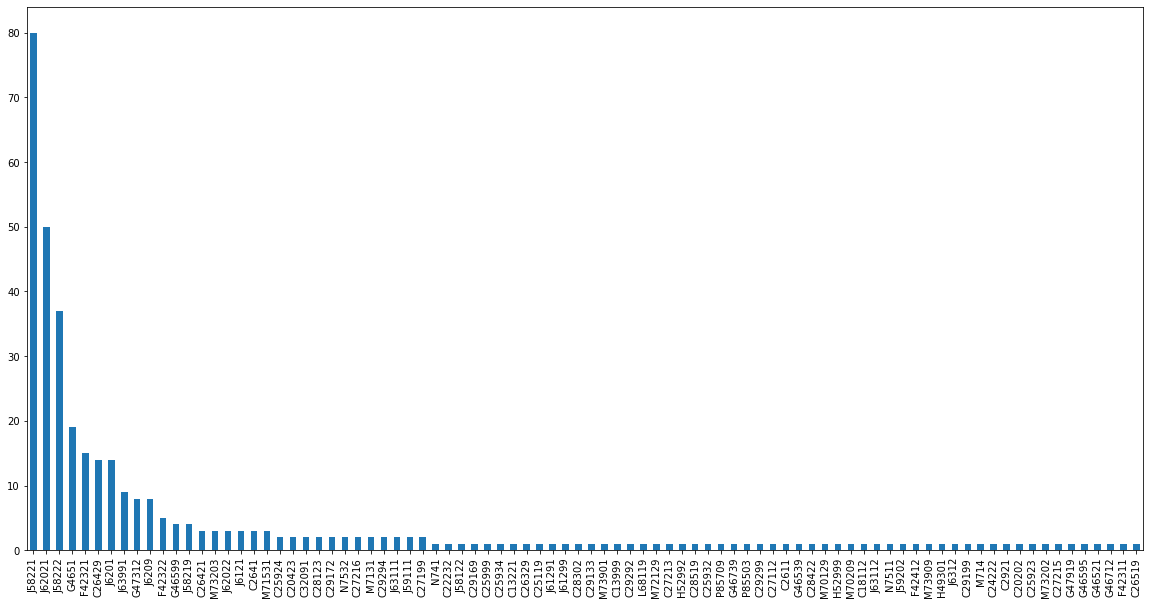

In [10]:
plt.rcParams["figure.figsize"] = (20, 10)

increase_cluster['산업분류코드'].value_counts().plot(kind='bar')

In [11]:
keep_industry = pd.DataFrame(keep_cluster['산업분류코드'].value_counts())
keep_industry.to_csv('매출정체산업.csv',encoding='euc-kr')

In [12]:
decrease_industry = pd.DataFrame(decrease_cluster['산업분류코드'].value_counts())
decrease_industry.to_csv('매출감소산업.csv',encoding='euc-kr')

In [14]:
crawling = pd.read_csv('크롤링1234.csv', encoding='euc-kr')

In [15]:
crawling['특허'] = crawling['특허'].fillna('[]')
crawling['특허'] = crawling['특허'].replace('[]','정보없음')
crawling['특허'].isna().sum()

0

In [16]:
crawling.columns = ['사업자번호', '재무', '상품', '산업군', '특허', '인증']

In [17]:
crawling

,사업자번호,재무,상품,산업군,특허,인증
0,1.058603e+09,결산년도 총자산 자본금 자본...,특허검색서비스,데이터베이스 및 온라인정보 제공업,"['10-1623902,2016', '10-1575797,2015', '10-157...","['이노비즈인증,2018', '경영혁신형중소기업,2016', '벤처기업확인,2014']"
1,1.058528e+09,Empty DataFrame\nColumns: [결산년도 총자산 자본금 자본총계 매...,정보없음,정보없음,정보없음,정보없음
2,1.058668e+09,결산년도 총자산 자본금 자본총계 ...,위성 및 항공영상 처리 S/W,응용소프트웨어 개발 및 공급업,정보없음,"['벤처기업확인,2020', '이노비즈인증,2018']"
3,1.138186e+09,결산년도 총자산 자본금 자본총계 ...,냉동공조제품,배관 및 냉·난방 공사업,정보없음,[]
4,2.288701e+09,결산년도 총자산 자본금 자본총계 ...,정보없음,응용소프트웨어 개발 및 공급업,정보없음,[]
...,...,...,...,...,...,...
9530,1.428184e+09,결산년도 총자산 자본금 자본총계 ...,"해양플랜트 설계, 조선해양관련엔지니어링업 등",기타 엔지니어링 서비스업,정보없음,NaN
9531,3.948601e+09,결산년도 총자산 자본금 자본총계 매출...,컴퓨터 프로그래밍 외,컴퓨터 프로그래밍 서비스업,정보없음,NaN
9532,2.208889e+09,Empty DataFrame\r\nColumns: 결산년도 총자산 자본금 자본총계 ...,정보없음,정보없음,정보없음,정보없음
9533,1.208820e+09,결산년도 총자산 자본금 자본총계 ...,식자재 주문 플랫폼,컴퓨터 프로그래밍 서비스업,정보없음,"벤처기업확인,2019'"


In [18]:
cluster_data = pd.merge(cluster_data, crawling, on='사업자번호', how='left')

In [19]:
patent_yes = []

for i in range(len(crawling)):
  if len(crawling['특허'][i].split(',')) > 1:
    patent_yes.append(crawling.iloc[i,:])

In [20]:
finance_list = []

for i in range(len(patent_yes)):
  sales = patent_yes[i]['재무']
  if len(sales.split()) == 47:
    finance = pd.DataFrame({sales.split()[0]: sales.split()[8::8], sales.split()[1]: sales.split()[9::8], sales.split()[2]: sales.split()[10::8],
                        sales.split()[3]: sales.split()[11::8], sales.split()[4]: sales.split()[12::8], sales.split()[5]: sales.split()[13::8],
                        sales.split()[6]: sales.split()[14::8]})
    finance_list.append(finance)

In [21]:
#특허 수
patent_num = []

for i in range(len(patent_yes)):
  num = patent_yes[i]['특허']
  patent_num.append(len(num.split(',')) / 2)

In [22]:
company_patent=[]

for i in range(len(patent_yes)):
    pp = pd.DataFrame(patent_yes[i]).transpose().append({'특허수': patent_num[i]}, ignore_index=True)
    pp['특허수'] = pp.iloc[1,-1]
    pp.dropna(axis=0, inplace=True)
    company_patent.append(pd.DataFrame(pp))

In [23]:
patent_df = pd.DataFrame()

for i in range(len(company_patent)):
    patent_df = pd.concat([patent_df, company_patent[i]], axis=0)

In [24]:
# patent_df.to_csv('특허수.csv', encoding='euc-kr')

In [25]:
patent_df.columns = ['사업자번호','재무','상품','산업군','특허','인증','특허수']

In [26]:
patent_df.reset_index(drop=True,inplace=True)
patent_df

,사업자번호,재무,상품,산업군,특허,인증,특허수
0,1058602802.0,결산년도 총자산 자본금 자본...,특허검색서비스,데이터베이스 및 온라인정보 제공업,"['10-1623902,2016', '10-1575797,2015', '10-157...","['이노비즈인증,2018', '경영혁신형중소기업,2016', '벤처기업확인,2014']",14.0
1,2208615514.0,결산년도 총자산 자본금 자본...,"야외용 운동기구, 놀이시설","체조, 육상 및 체력단련용 장비 제조업","['JK-18568,2018', 'JEK-23148,2018']","['벤처기업확인,2021', '이노비즈인증,2019']",2.0
2,2148626563.0,결산년도 총자산 자본금 자본총계 ...,"유전체 염기서열 분석, DNA 올리고 합성, 클로닝/단백질 정제 등",물질성분 검사 및 분석업,"['Q239312,2018']","['벤처기업확인,2017', '이노비즈인증,2017']",1.0
3,2208725270.0,결산년도 총자산 자본금 자본총계 ...,"클릭뷰 QlikView, 웹튠 WebTune, SmartCDW 외 BI 구축, 빅데...",시스템 소프트웨어 개발 및 공급업,"['KOR-3134,2018']","['이노비즈인증,2018']",1.0
4,2098121090.0,결산년도 총자산 자본금 자본총계 ...,"거울, 시계",판유리 가공품 제조업,"['RQM2766,2019']","['이노비즈인증,2020']",1.0
...,...,...,...,...,...,...,...
675,1388174581.0,결산년도 총자산 자본금 자본총계 ...,홈페이지제작,응용소프트웨어 개발 및 공급업,"-191525,2019'","벤처기업확인,2012'",1.0
676,1308675150.0,결산년도 총자산 자본금 자본총계 ...,소프트웨어 개발 및 공급업,응용소프트웨어 개발 및 공급업,"AQ-18E031,2018'","벤처기업확인,2017'",1.0
677,1178183725.0,결산년도 총자산 자본금 자본총계 ...,수학 교구,교시용 모형 제조업,"특허-2016-0158866,2020', '특허-2016-0160905,2020'","벤처기업확인,2015'",2.0
678,2638600153.0,결산년도 총자산 자본금 자본총계 ...,스마트 세탁소 플랫폼,응용소프트웨어 개발 및 공급업,"10-1720263,2017'","벤처기업확인,2019'",1.0


In [27]:
cluster_data = pd.merge(cluster_data, patent_df, on='사업자번호', how='left')
cluster_data

,Unnamed: 0,사업자번호,Cluster,산업분류코드,기업코드,최종연구개발점수,최종연구개발등급,연구개발투자점수,인적자원구성원 등급,연구개발기술지원점수,...,상품_x,산업군_x,특허_x,인증_x,재무_y,상품_y,산업군_y,특허_y,인증_y,특허수
0,0,6138145291,Cluster 1,F42321,NaN,NaN,NaN,NaN,NaN,NaN,...,플라스틱,일반 통신 공사업,정보없음,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1248127527,Cluster 1,F42321,NaN,NaN,NaN,NaN,NaN,NaN,...,"전기, 통신공사",일반 통신 공사업,"KQA-OH21140,2021', '제 KQA-E10570 호,2019', '제 K...","경영혁신형중소기업,2020'",결산년도 총자산 자본금 자본총계 ...,"전기, 통신공사",일반 통신 공사업,"KQA-OH21140,2021', '제 KQA-E10570 호,2019', '제 K...","경영혁신형중소기업,2020'",3.0
2,2,3058172470,Cluster 1,J58221,151.0,82.5,B,45.0,A,22.5,...,"웹사이트구축,솔루션개발, PC사용 교정시스템",시스템 소프트웨어 개발 및 공급업,정보없음,"['벤처기업확인,2020', '이노비즈인증,2018', '경영혁신형중소기업,2018']",NaN,NaN,NaN,NaN,NaN,NaN
3,3,2298130593,Cluster 1,J58222,NaN,NaN,NaN,NaN,NaN,NaN,...,S/W개발,응용소프트웨어 개발 및 공급업,"['19-0502,2019', '18-0328,2018']","['이노비즈인증,2020', '경영혁신형중소기업,2014']",결산년도 총자산 자본금 자본총...,S/W개발,응용소프트웨어 개발 및 공급업,"['19-0502,2019', '18-0328,2018']","['이노비즈인증,2020', '경영혁신형중소기업,2014']",2.0
4,4,1058758282,Cluster 1,J59112,NaN,NaN,NaN,NaN,NaN,NaN,...,애니메이션제작 및 배급 외,애니메이션 영화 및 비디오물 제작업,정보없음,"['벤처기업확인,2020', '이노비즈인증,2019']",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4003,4002,2061049750,Cluster 9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"전자상거래, 컨설팅, 건강식품 등",전자상거래업,정보없음,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4004,4003,2148768560,Cluster 9,J58221,1800.0,64.5,D,30.0,D,22.5,...,정보없음,시스템 소프트웨어 개발 및 공급업,정보없음,[],NaN,NaN,NaN,NaN,NaN,NaN
4005,4004,3148643616,Cluster 9,J62021,6084.0,64.5,D,30.0,D,22.5,...,"프로그래밍,시스템통합,관리,웹디자인",컴퓨터시스템 통합 자문 및 구축 서비스업,정보없음,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4006,4005,2090388749,Cluster 9,J58222,NaN,NaN,NaN,NaN,NaN,NaN,...,소프트웨어,응용소프트웨어 개발 및 공급업,정보없음,[],NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
cluster_patent = cluster_data[cluster_data['특허수'].values > 0]
cluster_patent

,Unnamed: 0,사업자번호,Cluster,산업분류코드,기업코드,최종연구개발점수,최종연구개발등급,연구개발투자점수,인적자원구성원 등급,연구개발기술지원점수,...,상품_x,산업군_x,특허_x,인증_x,재무_y,상품_y,산업군_y,특허_y,인증_y,특허수
1,1,1248127527,Cluster 1,F42321,NaN,NaN,NaN,NaN,NaN,NaN,...,"전기, 통신공사",일반 통신 공사업,"KQA-OH21140,2021', '제 KQA-E10570 호,2019', '제 K...","경영혁신형중소기업,2020'",결산년도 총자산 자본금 자본총계 ...,"전기, 통신공사",일반 통신 공사업,"KQA-OH21140,2021', '제 KQA-E10570 호,2019', '제 K...","경영혁신형중소기업,2020'",3.0
3,3,2298130593,Cluster 1,J58222,NaN,NaN,NaN,NaN,NaN,NaN,...,S/W개발,응용소프트웨어 개발 및 공급업,"['19-0502,2019', '18-0328,2018']","['이노비즈인증,2020', '경영혁신형중소기업,2014']",결산년도 총자산 자본금 자본총...,S/W개발,응용소프트웨어 개발 및 공급업,"['19-0502,2019', '18-0328,2018']","['이노비즈인증,2020', '경영혁신형중소기업,2014']",2.0
6,6,4098190412,Cluster 1,J62021,5997.0,84.5,B,46.0,A,22.5,...,"시스템 통합(SI) 및 네트워크통합(NI), IT컨설팅 및 전산시스템 유지보수용역",컴퓨터시스템 통합 자문 및 구축 서비스업,"KQC-4776,2015'","이노비즈인증,2021', '경영혁신형중소기업,2020', '벤처기업확인,2020'",결산년도 총자산 자본금 자본총계 ...,"시스템 통합(SI) 및 네트워크통합(NI), IT컨설팅 및 전산시스템 유지보수용역",컴퓨터시스템 통합 자문 및 구축 서비스업,"KQC-4776,2015'","이노비즈인증,2021', '경영혁신형중소기업,2020', '벤처기업확인,2020'",1.0
11,11,1138157661,Cluster 1,C27219,1612.0,79.0,C,39.0,C,24.0,...,"기상관측장비, 온습도센서 외","기타 측정, 시험, 항해, 제어 및 정밀기기 제조업","['QI1283/06,2009']","['이노비즈인증,2019', '벤처기업확인,2019', '경영혁신형중소기업,2016']",결산년도 총자산 자본금 자본총계 ...,"기상관측장비, 온습도센서 외","기타 측정, 시험, 항해, 제어 및 정밀기기 제조업","['QI1283/06,2009']","['이노비즈인증,2019', '벤처기업확인,2019', '경영혁신형중소기업,2016']",1.0
25,25,1148685559,Cluster 1,G47311,NaN,NaN,NaN,NaN,NaN,NaN,...,"소프트웨어, 디지털 콘텐츠","컴퓨터 및 주변장치, 소프트웨어 소매업","['Q150914,2014']","['이노비즈인증,2014', '벤처기업확인,2012']",결산년도 총자산 자본금 자본총계 ...,"소프트웨어, 디지털 콘텐츠","컴퓨터 및 주변장치, 소프트웨어 소매업","['Q150914,2014']","['이노비즈인증,2014', '벤처기업확인,2012']",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3951,3950,2118620935,Cluster 7,F42311,NaN,NaN,NaN,NaN,NaN,NaN,...,건축설계감리,일반전기 공사업,"['AC-03718,2004']",[],결산년도 총자산 자본금 자본총계 ...,건축설계감리,일반전기 공사업,"['AC-03718,2004']",[],1.0
3973,3972,3148642577,Cluster 8,J62021,4599.0,84.5,B,46.0,A,22.5,...,"전산시스템 설계,구축 및 유지보수",컴퓨터시스템 통합 자문 및 구축 서비스업,",2015'","벤처기업확인,2015'",결산년도 총자산 자본금 자본총계 ...,"전산시스템 설계,구축 및 유지보수",컴퓨터시스템 통합 자문 및 구축 서비스업,",2015'","벤처기업확인,2015'",1.0
3974,3973,3148128978,Cluster 9,C2612,NaN,NaN,NaN,NaN,NaN,NaN,...,Photodiode 외,"다이오드, 트랜지스터 및 유사 반도체소자 제조업","KQA-E05267,2017', 'KQA-Q05187,2016'","이노비즈인증,2016', '벤처기업확인,2016'",결산년도 총자산 자본금 자본총계 ...,Photodiode 외,"다이오드, 트랜지스터 및 유사 반도체소자 제조업","KQA-E05267,2017', 'KQA-Q05187,2016'","이노비즈인증,2016', '벤처기업확인,2016'",2.0
3992,3991,1238621506,Cluster 9,C26429,NaN,NaN,NaN,NaN,NaN,NaN,...,통신장비(중계기) 외,기타 무선 통신장비 제조업,"Q394812,2012', 'E214512,2012'","이노비즈인증,2018'",결산년도 총자산 자본금 자본총계 ...,통신장비(중계기) 외,기타 무선 통신장비 제조업,"Q394812,2012', 'E214512,2012'","이노비즈인증,2018'",2.0


In [29]:
cluster_patent_sales = []
pl = []
pk = []
pj = []
ph = []
pg = []
pc = []
pn = []
RND_score = []
mmmm = []
final_sales = []

for i in range(len(cluster_patent)):
    cluster_patent_sales.append(cluster_patent.iloc[i,-6])
    if len(cluster_patent_sales[i].split()) == 47:
        test = pd.DataFrame({cluster_patent_sales[i].split()[0]: cluster_patent_sales[i].split()[8::8], cluster_patent_sales[i].split()[1]: cluster_patent_sales[i].split()[9::8], cluster_patent_sales[i].split()[2]: cluster_patent_sales[i].split()[10::8],
                    cluster_patent_sales[i].split()[3]: cluster_patent_sales[i].split()[11::8], cluster_patent_sales[i].split()[4]: cluster_patent_sales[i].split()[12::8], cluster_patent_sales[i].split()[5]: cluster_patent_sales[i].split()[13::8],
                    cluster_patent_sales[i].split()[6]: cluster_patent_sales[i].split()[14::8]})
        pl.append(test.iloc[0,4])
        pk.append(test.iloc[0,3])
        pj.append(test.iloc[0,2])
        ph.append(test.iloc[0,1])
        pg.append(test.iloc[0,0])
        pc.append(cluster_patent.iloc[i,1])
        pn.append(cluster_patent.iloc[i,-1])
        RND_score.append(cluster_patent.iloc[i,5])
        mmmm.append(test)

In [30]:
code_patent = pd.concat([pd.DataFrame(pc), pd.DataFrame(pn)], axis=1)
patent_sales = pd.concat([code_patent, pd.DataFrame(pk)], axis=1)
patent_sales = pd.concat([patent_sales, pd.DataFrame(ph)], axis=1)
patent_sales = pd.concat([patent_sales, pd.DataFrame(pj)], axis=1)
patent_sales = pd.concat([patent_sales, pd.DataFrame(pk)], axis=1)
patent_sales = pd.concat([patent_sales, pd.DataFrame(pl)], axis=1)
patent_sales.columns = ['사업자번호', '특허수', '가장옛날매출', '조금옛날매출', '가운데매출', '조금최근매출', '가장최근매출']
patent_sales

,사업자번호,특허수,가장옛날매출,조금옛날매출,가운데매출,조금최근매출,가장최근매출
0,1248127527,3.0,3906458,5373018,499999,3906458,6002015
1,2298130593,2.0,7728792,17170932,1285215,7728792,23764023
2,4098190412,1.0,4603211,7825931,349999,4603211,27318175
3,1138157661,1.0,4377087,10732171,599999,4377087,9780418
4,1148685559,1.0,2255563,4240598,200000,2255563,7634907
...,...,...,...,...,...,...,...
471,2118620935,1.0,4986528,9056833,700000,4986528,9600450
472,3148642577,1.0,425576,2423966,300000,425576,4945356
473,3148128978,2.0,3036852,5755993,812275,3036852,2744743
474,1238621506,2.0,-535479,6894497,500000,-535479,3648489


In [31]:
patent_sales.to_csv('특허기업.csv', encoding='euc-kr')

In [32]:
patent_sales.astype(float).corr(method='pearson')

,사업자번호,특허수,가장옛날매출,조금옛날매출,가운데매출,조금최근매출,가장최근매출
사업자번호,1.000000,0.020289,-0.043255,-0.160392,-0.085462,-0.043255,-0.172786
특허수,0.020289,1.000000,0.171220,0.141184,0.143521,0.171220,0.010604
가장옛날매출,-0.043255,0.171220,1.000000,0.745059,0.208056,1.000000,0.418030
조금옛날매출,-0.160392,0.141184,0.745059,1.000000,0.286707,0.745059,0.614585
가운데매출,-0.085462,0.143521,0.208056,0.286707,1.000000,0.208056,0.131791
조금최근매출,-0.043255,0.171220,1.000000,0.745059,0.208056,1.000000,0.418030
가장최근매출,-0.172786,0.010604,0.418030,0.614585,0.131791,0.418030,1.000000


In [33]:
increase_cluster

,Unnamed: 0,사업자번호,Cluster,산업분류코드,기업코드,최종연구개발점수,최종연구개발등급,연구개발투자점수,인적자원구성원 등급,연구개발기술지원점수,...,사업계획 점수,사업계획 등급,경제적 책임 점수,경제적 책임 등급,법률적 책임 점수,법률적 책임 등급,윤리적 책임 점수,윤리적 책임 등급,자선적 책임 점수,자선적 책임 등급
1564,1564,1301287524,Cluster 3,G47312,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1565,1565,6211653979,Cluster 3,C29299,9385.0,60.0,D,30.0,D,18.0,...,70.0,C,50.0,D,80.0,B,80.0,B,50.0,D
1566,1566,1400938689,Cluster 3,C29294,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1567,1567,1390862616,Cluster 3,C29294,8915.0,60.0,D,30.0,D,18.0,...,50.0,D,100.0,A,100.0,A,100.0,A,50.0,D
1568,1568,1302668499,Cluster 3,C18112,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,3596,2068676868,Cluster 60,G46595,7180.0,64.5,D,30.0,D,22.5,...,50.0,D,60.0,D,100.0,A,100.0,A,50.0,D
3597,3597,1078674001,Cluster 60,J58221,7773.0,60.0,D,30.0,D,18.0,...,90.0,A,60.0,D,100.0,A,100.0,A,50.0,D
3598,3598,2158185992,Cluster 60,C26429,1144.0,60.0,D,30.0,D,18.0,...,90.0,A,70.0,C,90.0,A,100.0,A,60.0,D
3599,3599,1408139796,Cluster 60,C25119,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
mkm = pd.merge(patent_sales, increase_cluster, on='사업자번호', how='left')
mkm

,사업자번호,특허수,가장옛날매출,조금옛날매출,가운데매출,조금최근매출,가장최근매출,Unnamed: 0,Cluster,산업분류코드,...,사업계획 점수,사업계획 등급,경제적 책임 점수,경제적 책임 등급,법률적 책임 점수,법률적 책임 등급,윤리적 책임 점수,윤리적 책임 등급,자선적 책임 점수,자선적 책임 등급
0,1248127527,3.0,3906458,5373018,499999,3906458,6002015,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2298130593,2.0,7728792,17170932,1285215,7728792,23764023,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4098190412,1.0,4603211,7825931,349999,4603211,27318175,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1138157661,1.0,4377087,10732171,599999,4377087,9780418,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1148685559,1.0,2255563,4240598,200000,2255563,7634907,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,2118620935,1.0,4986528,9056833,700000,4986528,9600450,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
472,3148642577,1.0,425576,2423966,300000,425576,4945356,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
473,3148128978,2.0,3036852,5755993,812275,3036852,2744743,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
474,1238621506,2.0,-535479,6894497,500000,-535479,3648489,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
kmk = []

for i in range(len(mkm)):
    if mkm.iloc[i,5] in mkm['Cluster'].value_counts().index:
        kmk.append(mkm.iloc[i,:])

In [42]:
mlp = pd.DataFrame()

for i in range(len(kmk)):
    mlp = pd.concat([mlp, pd.DataFrame(kmk[i]).transpose()], axis=0)
    mlp = mlp.sort_values('최근매출액', ascending=True)
plt.scatter(x=mlp['특허수'], y=mlp['최근매출액'])
plt.show()

KeyError: '특허수'

특허 수와 클러스터링별 비교 분석

In [44]:
patent_company = pd.read_csv('특허기업.csv', encoding='euc-kr')
sale_increase = pd.read_csv('매출증가사업자.csv', encoding='euc-kr') 
sale_decrease = pd.read_csv('매출감소사업자.csv', encoding='euc-kr')
sale_keep = pd.read_csv('매출정체사업자.csv', encoding='euc-kr')

In [45]:
patent_sale_increase= pd.merge(patent_company, sale_increase, on='사업자번호', how='left')
patent_sale_decrease= pd.merge(patent_company, sale_decrease, on='사업자번호', how='left')
patent_sale_keep= pd.merge(patent_company, sale_keep, on='사업자번호', how='left')

In [46]:
patent_sale_increase.head()

,Unnamed: 0_x,사업자번호,특허수,가장옛날매출,조금옛날매출,가운데매출,조금최근매출,가장최근매출,Unnamed: 0_y,Unnamed: 0.1,...,사업계획 점수,사업계획 등급,경제적 책임 점수,경제적 책임 등급,법률적 책임 점수,법률적 책임 등급,윤리적 책임 점수,윤리적 책임 등급,자선적 책임 점수,자선적 책임 등급
0,0,1248127527,3.0,3906458,5373018,499999,3906458,6002015,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2298130593,2.0,7728792,17170932,1285215,7728792,23764023,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,4098190412,1.0,4603211,7825931,349999,4603211,27318175,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1138157661,1.0,4377087,10732171,599999,4377087,9780418,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1148685559,1.0,2255563,4240598,200000,2255563,7634907,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
sale_change = []

for i in range(len(patent_sale_increase)):
    sale_change.append(patent_sale_increase.iloc[i,7] / patent_sale_increase.iloc[i,3] * 100)
patent_sale_corr = pd.concat([patent_sale_increase.iloc[:,1:3], pd.DataFrame(sale_change)], axis=1)
patent_sale_corr.columns = ['사업자번호', '특허수', '매출변동률']
patent_sale_corr.corr(method='pearson')

,사업자번호,특허수,매출변동률
사업자번호,1.000000,0.020289,-0.128752
특허수,0.020289,1.000000,-0.077249
매출변동률,-0.128752,-0.077249,1.000000


단순 특허 수 와는 무의미

---

In [48]:
patent_year = []
patent_code = []
final_patent_year = []
final_patent_code = []

for patent in cluster_patent['특허_y'].replace("''",''):
    patent_list = patent.split(',')
    patent_year = []
    patent_code = []
    for i in range(len(patent_list)):
        if i % 2  == 0:
            patent_code.append(patent_list[i])
        elif i % 2 == 1:
            patent_year.append(patent_list[i])
    final_patent_code.append(patent_code)
    final_patent_year.append(patent_year)

In [49]:
for m in range(len(mmmm)):
    for n in range(len(mmmm[m]['결산년도'])):
        mmmm[m] = mmmm[m].append({'연도' : mmmm[m]['결산년도'][n][:4]}, ignore_index=True)
    mmmm[m].iloc[:5,-1] = mmmm[m].iloc[5:,-1]
    mmmm[m] = mmmm[m].iloc[:5,:]

In [50]:
len(mmmm)

476

In [51]:
len(final_patent_year)

476

In [52]:
k = 0
summ = 0
tmp = []
patent_effect = [] 
patent_effect_code = []

for m in range(len(mmmm)):
    for n in range(1,4):
        for t in range(len(final_patent_year[m])):
            if final_year[m][t] == mmmm[m].iloc[n,-1]:
                if float(mmmm[m].iloc[n-1,4]) != 0 and float(mmmm[m].iloc[n+1,4]) != 0:
                    tmp.append((float(mmmm[m].iloc[n+1,4]) - float(mmmm[m].iloc[n-1,4])) / float(mmmm[m].iloc[n-1,4]) * 100)

    if len(tmp) != 0:
        while k < len(tmp):
            summ += tmp[k]
            k += 1
        patent_effect.append(summ / len(tmp))
    else:
        patent_effect.append('데이터없음')

NameError: name 'final_year' is not defined

In [53]:
patent_effect = pd.DataFrame(patent_effect)
patent_effect.columns = ['특허매출효과']
patent_effect = pd.concat([patent_sales['사업자번호'], patent_effect], axis=1)

ValueError: Length mismatch: Expected axis has 0 elements, new values have 1 elements

In [978]:
patent_effect

,사업자번호,특허매출효과
0,1248127527,-19.815691
1,2298130593,-15.434562
2,4098190412,-15.434562
3,1138157661,-15.434562
4,1148685559,-15.434562
...,...,...
423,1248601084,1.326398
424,3148642577,1.326398
425,3148128978,1.251468
426,1238621506,1.251468


In [979]:
cluster_patent_copy = cluster_patent.copy()
cluster_patent_copy.drop('Unnamed: 0', axis=1, inplace=True)
cluster_patent_copy = cluster_patent_copy.iloc[:,:2]
cluster_patent_copy.reset_index(drop=True, inplace=True)
# cluster_patent_copy.to_csv('특허_사업자별클러스터.csv', encoding='euc-kr')

In [980]:
cluster_patent_copy

,사업자번호,Cluster
0,1248127527,Cluster 1
1,2298130593,Cluster 1
2,4098190412,Cluster 1
3,1138157661,Cluster 1
4,1148685559,Cluster 1
...,...,...
423,1248601084,Cluster 7
424,3148642577,Cluster 8
425,3148128978,Cluster 9
426,1238621506,Cluster 9


In [981]:
patent_effect = pd.concat([patent_effect, cluster_patent_copy], axis=1)
patent_effect

,사업자번호,특허매출효과,사업자번호,Cluster
0,1248127527,-19.815691,1248127527,Cluster 1
1,2298130593,-15.434562,2298130593,Cluster 1
2,4098190412,-15.434562,4098190412,Cluster 1
3,1138157661,-15.434562,1138157661,Cluster 1
4,1148685559,-15.434562,1148685559,Cluster 1
...,...,...,...,...
423,1248601084,1.326398,1248601084,Cluster 7
424,3148642577,1.326398,3148642577,Cluster 8
425,3148128978,1.251468,3148128978,Cluster 9
426,1238621506,1.251468,1238621506,Cluster 9


In [982]:
patent_effect.columns = ['사업자번호', '특허매출효과', '없애', 'Cluster']
patent_effect.drop(['없애'], axis=1, inplace=True)

In [983]:
patent_effect['특허매출효과'].median()

0.4927297657299769

----------

In [984]:
cluster_data['특허수'] = cluster_data['특허수'].fillna(0).values

In [926]:
cluster_no_patent = cluster_data[cluster_data['특허수'].values == 0]
cluster_no_patent.reset_index(drop=True, inplace=True)
cluster_no_patent.iloc[:,-11]

0                결산년도      총자산      자본금     자본총계      ...
1                결산년도        총자산      자본금       자본총계  ...
2                결산년도        총자산      자본금       자본총계  ...
3                결산년도      총자산      자본금      자본총계     ...
4                결산년도        총자산        자본금       자본총계...
                              ...                        
3575             결산년도      총자산      자본금     자본총계      ...
3576             결산년도        총자산      자본금     자본총계    ...
3577             결산년도      총자산      자본금     자본총계      ...
3578             결산년도        총자산      자본금     자본총계    ...
3579             결산년도        총자산      자본금     자본총계    ...
Name: 재무_x, Length: 3580, dtype: object

In [927]:
cluster_no_patent_sales = []
nnnn= []

for i in range(len(cluster_no_patent)):
    cluster_no_patent_sales.append(cluster_no_patent.iloc[i,-11])
    if len(cluster_no_patent_sales[i].split()) == 47:
        test = pd.DataFrame({cluster_no_patent_sales[i].split()[0]: cluster_no_patent_sales[i].split()[8::8], cluster_no_patent_sales[i].split()[1]: cluster_no_patent_sales[i].split()[9::8], cluster_no_patent_sales[i].split()[2]: cluster_no_patent_sales[i].split()[10::8],
                    cluster_no_patent_sales[i].split()[3]: cluster_no_patent_sales[i].split()[11::8], cluster_no_patent_sales[i].split()[4]: cluster_no_patent_sales[i].split()[12::8], cluster_no_patent_sales[i].split()[5]: cluster_no_patent_sales[i].split()[13::8],
                    cluster_no_patent_sales[i].split()[6]: cluster_no_patent_sales[i].split()[14::8]})
        nnnn.append(test)

In [948]:
tmp = []
summ = 0
k = 0
no_patent_effect = [] 


for m in range(len(nnnn)):
    for n in range(0,4):
        if float(nnnn[m].iloc[n-1,4]) != 0 and float(nnnn[m].iloc[n+1,4]) != 0:
            tmp.append((float(nnnn[m].iloc[n,4]) - float(nnnn[m].iloc[n+1,4])) / float(float(nnnn[m].iloc[n+1,4]) * 100))
    if len(tmp) != 0:
        while k < len(tmp):
            summ += tmp[k]
            k += 1
        no_patent_effect.append(summ / len(tmp))
    else:
        no_patent_effect.append('데이터없음')

In [949]:
no_patent_effect = pd.DataFrame(no_patent_effect)
no_patent_effect.columns = ['특허매출효과']

In [950]:
no_patent_effect

,특허매출효과
0,0.002356
1,0.004450
2,0.005241
3,0.004138
4,0.003386
...,...
2792,0.122973
2793,0.122927
2794,0.122881
2795,0.122836


In [951]:
cluster_no_patent_copy = cluster_no_patent.copy()
cluster_no_patent_copy.drop('Unnamed: 0', axis=1, inplace=True)
cluster_no_patent_copy = cluster_no_patent_copy.iloc[:,:2]

In [952]:
cluster_no_patent_copy = pd.concat([cluster_no_patent_copy, no_patent_effect], axis=1)
cluster_no_patent_copy.to_csv('특허0_사업자별클러스터.csv', encoding='euc-kr')
cluster_no_patent_copy['특허매출효과'].median()

0.009655113000666045

기업이 특허를 낼 경우, 특허 등록 이후 연도 매출이 등록 이전 연도 매출보다 약 0.5% 증가
기업이 특허를 내지 않을 경우, 매년 연도 상승률이 약 0.009%

----------------------

In [985]:
increase_cluster_patent = pd.merge(increase_cluster, patent_effect, on='사업자번호', how='left')
increase_cluster_patent = increase_cluster_patent[increase_cluster_patent['특허매출효과'] > 0]
increase_cluster_patent.reset_index(drop=True, inplace=True)
increase_cluster_patent['특허매출효과'].median()

1.184002907966178

In [986]:
keep_cluster_patent = pd.merge(keep_cluster, patent_effect, on='사업자번호', how='left')
keep_cluster_patent = keep_cluster_patent[keep_cluster_patent['특허매출효과'] > 0]
keep_cluster_patent.reset_index(drop=True, inplace=True)
keep_cluster_patent['특허매출효과'].median()

1.0062920076568485

In [987]:
decrease_cluster_patent = pd.merge(decrease_cluster, patent_effect, on='사업자번호', how='left')
decrease_cluster_patent = decrease_cluster_patent[decrease_cluster_patent['특허매출효과'] > 0]
decrease_cluster_patent.reset_index(drop=True, inplace=True)
decrease_cluster_patent['특허매출효과'].median()

2.379619161978434

매출이 증가하는 군집 대비 매출이 감소하는 군집에서 특허로 인한 매출 증가 효과가 약 2배로 나타남
1.184002907966178 | 2.379619161978434

>> 특허 이전 타당성 up! -> 특허 이전 플랫폼 활성화 

---------------

인증이 있는 기업의 인증 전후 상승률 비교

In [1010]:
cluster_data['인증_x'] = cluster_data['인증_x'].fillna(0)

In [1011]:
cluster_certify = cluster_data[cluster_data['인증_x'].values != 0]
cluster_certify.reset_index(drop=True, inplace=True)
len(cluster_certify['재무_x'])

1211

In [1012]:
certify_year = []
certify_code = []
final_yr = []
final_cd = []

for certify in cluster_certify['인증_x'].replace("''",''):
    certify_list = certify.split(',')
    certify_year = []
    certify_code = []
    for i in range(len(certify_list)):
        if i % 2  == 0:
            certify_code.append(certify_list[i])
        elif i % 2 == 1:
            certify_year.append(certify_list[i])
    final_cd.append(certify_code)
    final_yr.append(certify_year)

In [1013]:
certify_sales = []
mmmm= []

for i in range(len(cluster_certify)):
    certify_sales.append(cluster_certify['재무_x'][i])
    if len(certify_sales[i].split()) == 47:
        test = pd.DataFrame({certify_sales[i].split()[0]: certify_sales[i].split()[8::8], certify_sales[i].split()[1]: certify_sales[i].split()[9::8], certify_sales[i].split()[2]: certify_sales[i].split()[10::8],
                    certify_sales[i].split()[3]: certify_sales[i].split()[11::8], certify_sales[i].split()[4]: certify_sales[i].split()[12::8], certify_sales[i].split()[5]: certify_sales[i].split()[13::8],
                    certify_sales[i].split()[6]: certify_sales[i].split()[14::8]})
        mmmm.append(test)

In [1014]:
tmp = []
summ = 0
k = 0
certify_effect = [] 


for m in range(len(mmmm)):
    for n in range(0,4):
        if float(mmmm[m].iloc[n-1,4]) != 0 and float(mmmm[m].iloc[n+1,4]) != 0:
            tmp.append((float(mmmm[m].iloc[n,4]) - float(mmmm[m].iloc[n+1,4])) / float(float(mmmm[m].iloc[n+1,4]) * 100))
        else:
            tmp.append(0)
    if len(tmp) != 0:
        while k < len(tmp):
            summ += tmp[k]
            k += 1
        certify_effect.append(summ / len(tmp))
    else:
        certify_effect.append('데이터없음')

In [1015]:
certify_effect = pd.DataFrame(certify_effect)
certify_effect.columns = ['인증매출효과']

In [1016]:
cluster_data_copy3 = cluster_certify.copy()
cluster_data_copy3.drop('Unnamed: 0', axis=1, inplace=True)
cluster_data_copy3 = cluster_data_copy3.iloc[:,:2]

In [1018]:
cluster_data_copy3 = pd.concat([cluster_data_copy3, certify_effect], axis=1)
cluster_data_copy3.to_csv('인증_사업자별클러스터.csv', encoding='euc-kr') 
cluster_data_copy3['인증매출효과'].median()

0.004886734472610973

---------

In [1086]:
increase_cluster_certify = pd.merge(increase_cluster, cluster_data_copy3, on='사업자번호', how='left')
increase_cluster_certify = increase_cluster_certify[increase_cluster_certify['인증매출효과'] > 0]
increase_cluster_certify.reset_index(drop=True, inplace=True)
increase_cluster_certify['인증매출효과'].median()

0.004719435140021828

In [1087]:
keep_cluster_certify = pd.merge(keep_cluster, cluster_data_copy3, on='사업자번호', how='left')
keep_cluster_certify = keep_cluster_certify[keep_cluster_certify['인증매출효과'] > 0]
keep_cluster_certify.reset_index(drop=True, inplace=True)
keep_cluster_certify['인증매출효과'].median()

0.004537133513954578

In [1088]:
decrease_cluster_certify = pd.merge(decrease_cluster, cluster_data_copy3, on='사업자번호', how='left')
decrease_cluster_certify = decrease_cluster_certify[decrease_cluster_certify['인증매출효과'] > 0]
decrease_cluster_certify.reset_index(drop=True, inplace=True)
decrease_cluster_certify['인증매출효과'].median()

0.004869518505681208

클러스터 간 인증의 매출 증가 효과는 미미

---

인증이 없는 기업의 매출 연간 상승률 평균

In [1019]:
cluster_no_certify = cluster_data[cluster_data['인증_x'].values == 0]
cluster_no_certify.reset_index(drop=True, inplace=True)
len(cluster_no_certify['재무_x'])

2797

In [1020]:
certify_no_sales = []
nnnn = []

for i in range(len(cluster_no_certify)):
    certify_no_sales.append(cluster_no_certify['재무_x'][i])
    if len(certify_no_sales[i].split()) == 47:
        test = pd.DataFrame({certify_no_sales[i].split()[0]: certify_no_sales[i].split()[8::8], certify_no_sales[i].split()[1]: certify_no_sales[i].split()[9::8], certify_no_sales[i].split()[2]: certify_no_sales[i].split()[10::8],
                    certify_no_sales[i].split()[3]: certify_no_sales[i].split()[11::8], certify_no_sales[i].split()[4]: certify_no_sales[i].split()[12::8], certify_no_sales[i].split()[5]: certify_no_sales[i].split()[13::8],
                    certify_no_sales[i].split()[6]: certify_no_sales[i].split()[14::8]})
        nnnn.append(test)

In [1122]:
tmp = []
summ = 0
k = 0
certify_no_effect = [] 


for m in range(len(nnnn)):
    for n in range(0,4):
        if float(nnnn[m].iloc[n-1,4]) != 0 and float(nnnn[m].iloc[n+1,4]) != 0:
            tmp.append((float(nnnn[m].iloc[n,4]) - float(nnnn[m].iloc[n+1,4])) / float(float(nnnn[m].iloc[n+1,4]) * 100))
        else:
            tmp.append(0)
    if len(tmp) != 0:
        while k < len(tmp):
            summ += tmp[k]
            k += 1
        certify_no_effect.append(summ / len(tmp))
    else:
        certify_no_effect.append('데이터없음')

In [1123]:
certify_no_effect = pd.DataFrame(certify_no_effect)
certify_no_effect.columns = ['인증매출효과']

In [1124]:
cluster_data_copy4 = cluster_no_certify.copy()
cluster_data_copy4.drop('Unnamed: 0', axis=1, inplace=True)
cluster_data_copy4 = cluster_data_copy4.iloc[:,:2]

In [1125]:
cluster_data_copy4 = pd.concat([cluster_data_copy4, certify_no_effect], axis=1)
cluster_data_copy4.to_csv('인증0_사업자별클러스터.csv', encoding='euc-kr')
cluster_data_copy4['인증매출효과'].median()

0.00943052478046085

인증 후 기업들의 평균 매출액 증가율: 0.004886734472610973

인증 없는 기업들의 평균 매출액 증가율: 0.00943052478046085

-------

이노비즈 여부에 따른 매출 비교

In [1051]:
cluster_innobiz = cluster_data[cluster_data['인증_x'].values != 0]
cluster_innobiz.reset_index(drop=True, inplace=True)

In [1095]:
innobiz_year = []
innobiz_code = []
innobiz_yr = []
innobiz_cd = []
innobiz_df = pd.DataFrame()

cluster_innobiz['인증_x'] = cluster_innobiz['인증_x'].replace("''",'')

for m in range(len(cluster_innobiz)):
    innobiz_list = cluster_innobiz['인증_x'][m].split(',')
    innobiz_year = []
    innobiz_code = []
    for i in range(0,len(innobiz_list),2):
        if innobiz_list[i] == '이노비즈인증':
            innobiz_year.append(innobiz_list[i+1])
            innobiz_df = pd.concat([innobiz_df, pd.DataFrame(cluster_innobiz.iloc[i,:]).transpose()], axis=0)
    innobiz_yr.append(innobiz_year)

<ipython-input-1095-3c5e39df1126>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_innobiz['인증_x'] = cluster_innobiz['인증_x'].replace("''",'')


In [1096]:
innobiz_df.reset_index(drop=True, inplace=True)

In [1097]:
innobiz_sales = []
mmmm= []

for i in range(len(innobiz_df)):
    innobiz_sales.append(innobiz_df['재무_x'][i])
    if len(innobiz_sales[i].split()) == 47:
        test = pd.DataFrame({innobiz_sales[i].split()[0]: innobiz_sales[i].split()[8::8], innobiz_sales[i].split()[1]: innobiz_sales[i].split()[9::8], innobiz_sales[i].split()[2]: innobiz_sales[i].split()[10::8],
                    innobiz_sales[i].split()[3]: innobiz_sales[i].split()[11::8], innobiz_sales[i].split()[4]: innobiz_sales[i].split()[12::8], innobiz_sales[i].split()[5]: innobiz_sales[i].split()[13::8],
                    innobiz_sales[i].split()[6]: innobiz_sales[i].split()[14::8]})
        mmmm.append(test)

In [1109]:
tmp = []
summ = 0
k = 0
innobiz_effect = [] 


for m in range(len(mmmm)):
    for n in range(0,4):
        if float(mmmm[m].iloc[n-1,4]) != 0 and float(mmmm[m].iloc[n+1,4]) != 0:
            tmp.append((float(mmmm[m].iloc[n,4]) - float(mmmm[m].iloc[n+1,4])) / float(float(mmmm[m].iloc[n+1,4]) * 100))
        else:
            tmp.append(0)
    if len(tmp) != 0:
        while k < len(tmp):
            summ += tmp[k]
            k += 1
        innobiz_effect.append(summ / len(tmp))
    else:
        innobiz_effect.append('데이터없음')

In [1110]:
innobiz_effect = pd.DataFrame(innobiz_effect)
innobiz_effect.columns = ['인증매출효과']

In [1111]:
cluster_data_copy5 = cluster_certify.copy()
cluster_data_copy5.drop('Unnamed: 0', axis=1, inplace=True)
cluster_data_copy5 = cluster_data_copy5.iloc[:,:2]

In [1112]:
cluster_data_copy5 = pd.concat([cluster_data_copy5,innobiz_effect], axis=1)
cluster_data_copy5.dropna(axis=0, inplace=True)
# cluster_data_copy5.to_csv('이노비즈인증_사업자별클러스터.csv', encoding='euc-kr')
cluster_data_copy5['인증매출효과'].median()

0.0017203992032083625

이노비즈 인증 받은 후 매출 증가율: 0.0017203992032083625

---

In [1126]:
increase_cluster_innobiz = pd.merge(increase_cluster, cluster_data_copy5, on='사업자번호', how='left')
increase_cluster_innobiz = increase_cluster_innobiz[increase_cluster_innobiz['인증매출효과'] > 0]
increase_cluster_innobiz.reset_index(drop=True, inplace=True)
increase_cluster_innobiz['인증매출효과'].median()

nan

In [1129]:
keep_cluster_innobiz = pd.merge(keep_cluster, cluster_data_copy5, on='사업자번호', how='left')
keep_cluster_innobiz = keep_cluster_innobiz[keep_cluster_innobiz['인증매출효과'] > 0]
keep_cluster_innobiz.reset_index(drop=True, inplace=True)
keep_cluster_innobiz['인증매출효과'].median()

0.0017203992032083604

In [1130]:
decrease_cluster_innobiz = pd.merge(decrease_cluster, cluster_data_copy5, on='사업자번호', how='left')
decrease_cluster_innobiz = decrease_cluster_innobiz[decrease_cluster_innobiz['인증매출효과'] > 0]
decrease_cluster_innobiz.reset_index(drop=True, inplace=True)
decrease_cluster_innobiz['인증매출효과'].median()

0.0017203992032083636

매출이 증가하는 클러스터 중 이노비즈 인증을 받고 매출 증가 효과가 나타난 곳은 없다
